## Churn Modelling, notatnik II
Projekt zaliczeniowy Praktyczny Machine Learning w Pythonie <br>
Autor: Maciej Odziemczyk (388581)<br>
Wydział Nauk Ekonomicznych UW<br>
czerwiec 2020

##### Spis treści:
 - Dogłębne EDA:
     - analiza rozkładów każdej zmiennej, inżynieria:
         - logarytmowanie,
         - podział zmiennych ciągłych na kwartyle, decyle, ekspercki, "ewolucyjny",
         - badanie tablic liczebnościowych (na prawdopodobieństwach) dla zmiennych dyskretnych, w tym uzyskanych z powyższego punktu,
         - badanie interakcji Geography ze zmiennyhmi Age, EstimatedSalary, Balance,
         - normalizacja zmiennych ciągłych, unitaryzacja Tenure,
         - feature selection w oparciu o tablicę Mutable Information, Korelacji Spearmana, procedury od ogółu do szczegółu,
 - Ponowne szacowanie logitu, na nowych zmiennych (nieudane próby regularyzacji) **Uzyskanie wyników zbliżonych do Random Forest! ROC + 0.08, PR + 0.2**,
 - Próby z SVM i KNN (nieudane),
 - Weryfikacja hipotezy o nieprzydatności inżynierii zmiennych w przypadku algorytmów opartych o drzewa decyzyjne (XGB)

In [ ]:
import time
kernelstart = time.time()

In [1]:
# import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# zmiana ustawień wyświetlania dataframe
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 50)

In [3]:
df = pd.read_csv("Churn_Modelling.csv")

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


 - tenure: Ile czasu klient subskrybuje usługę - dyskretna od 1 do 10
 - CreditScore: ciągła
 - Age: ciągła
 - Balance: ciągła
 - EstimatedSalary: ciągła

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# usuwanie atrybutów bezpośrednio identyfikujących obserwacje
df.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [7]:
# sprawdzenie czy rzeczywiście nie ma braków danych
print('Nie ma nulli: {}'.format(df.dropna().shape == df.shape))

Nie ma nulli: True


In [8]:
# zmienne numeryczne
num = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

##### Zbadanie zbilanoswania danych

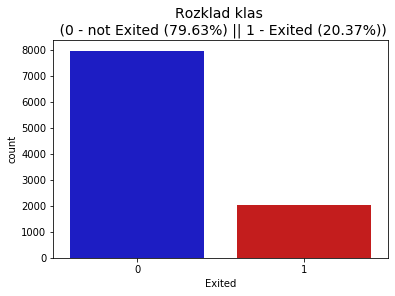

In [9]:
# rozkład etykiet - balans 
colors = ["#0101DF", "#DF0101"]

sns.countplot('Exited', data = df, palette = colors)
plt.title('Rozklad klas \n (0 - not Exited ({}%) || 1 - Exited ({}%))'.format(
    round((df.Exited.value_counts()[0]/df.shape[0])*100, 2),
    round((df.Exited.value_counts()[1]/df.shape[0])*100, 2)),
          fontsize=14)
plt.show()

Dysponowane dane charakteryzują się umiarkowanym niezbalansowaniem - potrzebna będzie **warstwowa walidacja krzyżowa**, ponadto, algorytmy takie jak **SVM** czy **KNN mogą okazać się mniej przydatne. Faworytami są** tutaj jak zawsze **Lasy Losowe, Extreme Gradient Boosting, Sieci Neuronowe**, oraz po inżynierii zmiennych być może **regresja logistyczna** osiągnie dobry wynik. **Naive Bayes** w problemie biznesowym nie wydaje się być istotnie dobrym algorytmem, zostanie on zatem **pominięty**.

In [10]:
# import funkcji
from hpl import subplotShape

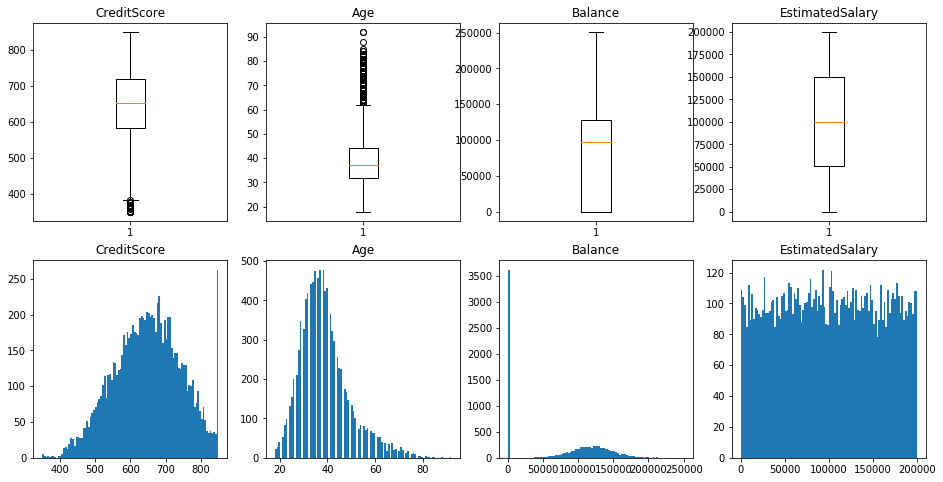

,CreditScore,Age,Balance,EstimatedSalary
count,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,76485.89,100090.24
std,96.65,10.49,62397.41,57510.49
min,350.00,18.00,0.00,11.58
25%,584.00,32.00,0.00,51002.11
50%,652.00,37.00,97198.54,100193.92
75%,718.00,44.00,127644.24,149388.25
max,850.00,92.00,250898.09,199992.48


In [11]:
# zwrot macierzy rozmiaru subplotów
rozmiar = subplotShape(np.array(num), 4)

# dodanie wiersza do macierzy
f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))
# technikalnia (wektory są zerowymiarowe)
ax = ax.reshape(-1, rozmiar[1])

# pętla rysująca wykresy
flag = 0
for r in range(rozmiar[0]):
    for c in range(rozmiar[1]):
        # widoczne tylko pola z wykresami
        ax[r, c].set_visible(False)
        ax[r+1, c].set_visible(False)
        # gdyby pól było więcej niż wykresów
        try:
            # rysowanie
            ax[r, c].boxplot(df[num[flag]])
            ax[r,c].set_title(num[flag])
            ax[r+1, c].hist(df[num[flag]], bins = 100)
            ax[r+1,c].set_title(num[flag])
            flag += 1
            ax[r, c].set_visible(True)
            ax[r+1, c].set_visible(True)
        except:
            pass

plt.show()
# statystyki opisowe
display(np.round(df[num].describe(), 2))

Z wykresów pudełkowych wynika, że nie ma błędnych obserwacji numerycznych, mało jest też wartości powyżej/poniżej 3Q + 3IQR, 1Q - 3IQR, dodatkowo, można zauważyć, że
 - credit score jest skośny lewostronnie, 
 - Age prawostronnie, minimum 18, Q3 to 44,
 - Balance wydaje się być rozdęty w zerze i mieć niską kurtozę, ale trzeba byłoby go sprawdzić bez zer,
 - Estimated Salary przypomina rozkład jednostajny.
 - Balance i Estimated Salary nie mają obserwacji  1/3Q +/- 3IQR
 - brak wniosków o obserwacjach błędnych (typu ujemny wiek) dodatkowo minimalny Balance to 0, czyli nie ma tu "kredytów".<br/>
 - można zauważyć, że zer jest faktycznie bardzo dużo w Balance, - przynajmniej 25%,
 - mediana wieku to 37, 4Q to 44, czyli jest wytłumaczenie outlierów

In [13]:
print('liczba obserwacji z max Credit score ({}): {}\n\
liczba unikalnych Credit score'.format(df.CreditScore.max(),
    df.CreditScore.where(df.CreditScore == df.CreditScore.max()).dropna().shape[0]),
     df.CreditScore.unique().shape[0])
print('Procent obserwacji z Balance == 0: {}%'.format(df.query('Balance == 0').shape[0]/df.shape[0]*100))

liczba obserwacji z max Credit score (850): 233
liczba unikalnych Credit score 460
Procent obserwacji z Balance == 0: 36.17%


##### Zmienna Balance
 - usunięcie zer,
 - logarytmowanie,
 - badanie normalności rozkładu po usunięciu zer (test Jarque-Bera)*,
 - podział decylowy,
 - wydzielenie zmiennej binarnej BalanceZero.
 
*Test Jarque-Bera jest testem asymptotycznym, oznacza to, że jego wyniki są poprawne jeżeli jest dużo obserwacji, w niniejszym przypadku jest ich 10 000.

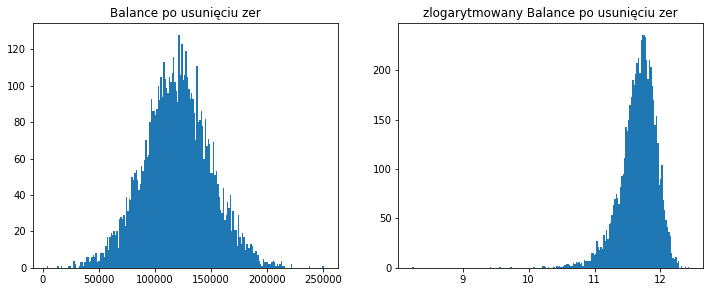

count      6383.00
mean     119827.49
std       30095.06
min        3768.69
25%      100181.98
50%      119839.69
75%      139512.29
max      250898.09
Name: Balance, dtype: float64

In [14]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.5))
ax[0].hist(df.Balance.where(df.Balance > 0).dropna(), bins = 200)
ax[0].set_title('Balance po usunięciu zer')
ax[1].hist(np.log(np.array(df.Balance.where(df.Balance > 0).dropna())), bins = 200)
ax[1].set_title('zlogarytmowany Balance po usunięciu zer')

plt.show()
display(round(df.Balance.where(df.Balance > 0).dropna().describe(), 2))

In [15]:
from scipy.stats import jarque_bera
print('Test Jarque Bera (p_value):',jarque_bera(np.array((df.Balance.where(df.Balance > 0).dropna())))[1])

Test Jarque Bera (p_value): 0.004163607040355011


Brak podstaw do przyjęcia Hipotezy zerowej o normalności rozkładu zmiennej Balance po usunięciu zer. Jednocześnie warto zauważyć symetrycznośc rozkładu, podział decylowy (ze względu na szeroki Rozstęp) może okazać się przydtny przy okazji inżynierii zmiennych.

In [16]:
print('---Decyle Balance---')
for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print('decyl {}: {}'.format(int(d*10), round(df.Balance.quantile(q = d)), 0))
print('-'*20)
print('Max (niezaokrąglony): {}'.format(df.Balance.max()))
print('-'*20)

---Decyle Balance---
decyl 1: 0.0
decyl 2: 0.0
decyl 3: 0.0
decyl 4: 73081.0
decyl 5: 97199.0
decyl 6: 110139.0
decyl 7: 122030.0
decyl 8: 133710.0
decyl 9: 149245.0
decyl 10: 250898.0
--------------------
Max (niezaokrąglony): 250898.09
--------------------


Widoczne rozdęcie w zerze (ponad 30% obserwacji).

In [17]:
# sprawdzenie czy zerowy Balance nie identyfikuje churnu
df.Exited.iloc[df.query('Balance == 0').index.tolist()].value_counts()

0    3117
1     500
Name: Exited, dtype: int64

In [18]:
# podział decylowy inplace
df["BalanceCut"] = pd.cut(df["Balance"], 
       [-0.1, 0.0, 73081.0, 97199.0, 110139.0, 122030.0, 133710.0, 149245.0, 250899], 
       labels = ['zero', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])

# Tabela liczebności - decyle balance, target
balCutExited = pd.crosstab(df.BalanceCut, df.Exited)

# dodanie kolumny prawdopodobienstw Churnu dla każdego decyla
balCutExited['prob'] = balCutExited[1]/(balCutExited[1]+balCutExited[0])
balCutExited

Exited,0,1,prob
BalanceCut,,,
zero,3117,500,0.138236
D4,293,90,0.234987
D5,802,198,0.198000
D6,752,248,0.248000
D7,716,284,0.284000
D8,745,255,0.255000
D9,766,234,0.234000
D10,772,228,0.228000


Decyle charakteryzują się podobnym prawdopodobienstwem Churnu, za wyjątkiem obserwacji zerowych, warto zatem sprawdzić podział Balance zero vs Balance not zero.

In [19]:
# podział
df["BalanceCutZero"] = pd.cut(df["Balance"], 
       [-0.1, 0.0, 250899], 
       labels = ['zero', 'notZero'])

# tablica liczebności
balCutZeroExited = pd.crosstab(df.BalanceCutZero, df.Exited)

# prawdopodobieństwa
balCutZeroExited['prob'] = balCutZeroExited[1]/(balCutZeroExited[1]+balCutZeroExited[0])
balCutZeroExited

Exited,0,1,prob
BalanceCutZero,,,
zero,3117,500,0.138236
notZero,4846,1537,0.240796


Wyraźna różnica między poziomami, zatem BalanceZero może być przydatną zmienną. <br/>
Można zauważyć, że jeżeli **Balance > 0** to **prawdopodobieństwo** churnu rośnie **dwukrotnie**.

##### Zmienna Age
 - logarytmowanie,
 - badanie normalności rozkładu po usunięciu zer (test Jarque-Bera)*,
 - podział kwartylowy,
 - znalezienie optymalnego/subpotymalnego podziału (kategoryzacja zmiennej).
 
*Test Jarque-Bera jest testem asymptotycznym, oznacza to, że jego wyniki są poprawne jeżeli jest dużo obserwacji, w niniejszym przypadku jest ich 10 000.

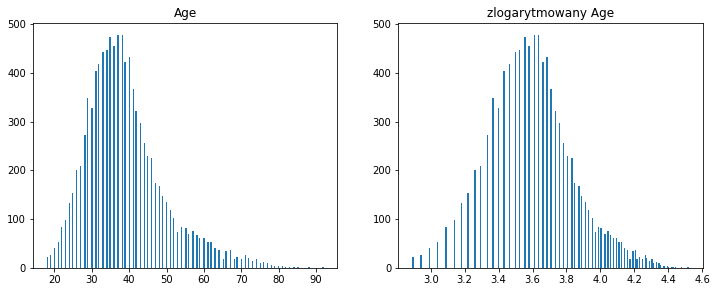

count    10000.00
mean        38.92
std         10.49
min         18.00
25%         32.00
50%         37.00
75%         44.00
max         92.00
Name: Age, dtype: float64

Test Jarque Bera (p_value):  8.326672684688674e-15


In [20]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.5))
ax[0].hist(df.Age, bins = 200)
ax[0].set_title('Age')
ax[1].hist(np.log(np.array(df.Age)), bins = 200)
ax[1].set_title('zlogarytmowany Age')
plt.show()

display(round(df.Age.describe(), 2))
print('Test Jarque Bera (p_value): ', jarque_bera(np.log(np.array(df.Age)))[1])

Brak podstaw do przyjęcia Hipotezy zerowej o normalności rozkładu zlogarytmowanego wieku, warto jednak zwrócić uwagę na rozkład - kwartyle, duża koncentracja wokół niewielkich przedziałów 32-37, 37-44, warto przeprowadzić testy analogiczne do tych przeprowadzonych przy badaniu zmiennej Balance, z tą różnicą, że lepiej uzasadniony wydaje się tu podział kwartylowy lub ręczny, gdyż z wysokim prawdopodobienstwem jesteśmy w stanie ekspercko wydzielić grupy wiekowe charakteryzujące się różnymi potrzebami, przykład:
 - 18-21
 - 22-25
 - 26-35
 - 36-45
 - 46-60
 - 60+

In [21]:
# liczebności grup z przykładu
pd.cut(df.Age, [18, 21, 25, 35, 45, 60, 100]).value_counts()

(35, 45]     3736
(25, 35]     3542
(45, 60]     1647
(21, 25]      469
(60, 100]     464
(18, 21]      120
Name: Age, dtype: int64

In [22]:
print('---Kwartyle Age---')
for d in [1/4, 1/2, 3/4, 1]:
    print('kwartyl {}: {}'.format(int(d*4), round(df.Age.quantile(q = d)), 0))
print('-'*20)
print('Min (niezaokrąglony): {}'.format(df.Age.min()))
print('-'*20)
print('Max (niezaokrąglony): {}'.format(df.Age.max()))
print('-'*20)

---Kwartyle Age---
kwartyl 1: 32.0
kwartyl 2: 37.0
kwartyl 3: 44.0
kwartyl 4: 92.0
--------------------
Min (niezaokrąglony): 18
--------------------
Max (niezaokrąglony): 92
--------------------


In [23]:
# podział
df["AgeCut"] = pd.cut(df["Age"], 
       [18.0, 32.0, 37.0, 44.0, 100.0], 
       labels = ['Q1', 'Q2', 'Q3', 'Q4'])

# tablica liczebności
ageCutExited = pd.crosstab(df.AgeCut, df.Exited)

# prawdopodobieństwa
ageCutExited['prob'] = ageCutExited[1]/(ageCutExited[1]+ageCutExited[0])
ageCutExited

Exited,0,1,prob
AgeCut,,,
Q1,2557,211,0.076228
Q2,2048,249,0.108402
Q3,2042,531,0.206374
Q4,1296,1044,0.446154


Można zauważyć, że starsi ludzie mają dużo większe prawdopodobieństwo churnu, Q1 i Q2 pomijalne różnice, Q3 przyrost 2x, Q4 przyrost 2x w stosunku do Q3. Być może warto doprecyzować przedziały, bowiem tendencja wzrosotwa może się załamywać, warto poszukać "jak najlepszych splitów", bo nie wątpliwie takowe występują. <br/>
 - Eksperymenty:

In [24]:
# podział
df["AgeCut35"] = pd.cut(df["Age"], 
       [18.0, 35.0, 100.0], 
       labels = ['<35', '>35'])

# tablica liczebności
ageCut35Exited = pd.crosstab(df.AgeCut35, df.Exited)

# prawdopodobienśtwa
ageCut35Exited['prob'] = ageCut35Exited[1]/(ageCut35Exited[1]+ageCut35Exited[0])
ageCut35Exited

Exited,0,1,prob
AgeCut35,,,
<35,3786,345,0.083515
>35,4157,1690,0.289037


In [25]:
# podział
df["AgeCut40"] = pd.cut(df["Age"], 
       [18.0, 40.0, 100.0], 
       labels = ['<40', '>40'])

# tablica liczebności
ageCut40Exited = pd.crosstab(df.AgeCut40, df.Exited)

# prawdopodobienśtwa
ageCut40Exited['prob'] = ageCut40Exited[1]/(ageCut40Exited[1]+ageCut40Exited[0])
ageCut40Exited

Exited,0,1,prob
AgeCut40,,,
<40,5713,684,0.106925
>40,2230,1351,0.377269


In [26]:
# podział
df["AgeCut50"] = pd.cut(df["Age"], 
       [18.0, 50.0, 100.0], 
       labels = ['<50', '>50'])

# tablica liczebności
ageCut50Exited = pd.crosstab(df.AgeCut50, df.Exited)

# prawdopodobienśtwa
ageCut50Exited['prob'] = ageCut50Exited[1]/(ageCut50Exited[1]+ageCut50Exited[0])
ageCut50Exited

Exited,0,1,prob
AgeCut50,,,
<50,7245,1472,0.168865
>50,698,563,0.446471


In [27]:
# podział
df["AgeCut60"] = pd.cut(df["Age"], 
       [18.0, 60.0, 100.0], 
       labels = ['<60', '>60'])

# tablica liczebności
ageCut60Exited = pd.crosstab(df.AgeCut60, df.Exited)

# prawdopodobienśtwa
ageCut60Exited['prob'] = ageCut60Exited[1]/(ageCut60Exited[1]+ageCut60Exited[0])
ageCut60Exited

Exited,0,1,prob
AgeCut60,,,
<60,7594,1920,0.201808
>60,349,115,0.247845


In [28]:
# podział
df["AgeCut4060"] = pd.cut(df["Age"], 
       [18.0, 40.0, 60.0, 100.0], 
       labels = ['<40', '40<x<60' , '>60'])

# tablica liczebności
ageCut4060Exited = pd.crosstab(df.AgeCut4060, df.Exited)

# prawdopodobieństwa
ageCut4060Exited['prob'] = ageCut4060Exited[1]/(ageCut4060Exited[1]+ageCut4060Exited[0])
ageCut4060Exited

Exited,0,1,prob
AgeCut4060,,,
<40,5713,684,0.106925
40<x<60,1881,1236,0.396535
>60,349,115,0.247845


In [29]:
# podział
df["AgeCut4065"] = pd.cut(df["Age"], 
       [18.0, 40.0, 65.0, 100.0], 
       labels = ['<40', '40<x<65' , '>65'])

# tablica liczebności
ageCut4065Exited = pd.crosstab(df.AgeCut4065, df.Exited)

# prawdopodobieństwa
ageCut4065Exited['prob'] = ageCut4065Exited[1]/(ageCut4065Exited[1]+ageCut4065Exited[0])
ageCut4065Exited

Exited,0,1,prob
AgeCut4065,,,
<40,5713,684,0.106925
40<x<65,2001,1316,0.396744
>65,229,35,0.132576


In [30]:
# podział
df["AgeCut3565"] = pd.cut(df["Age"], 
       [18.0, 35.0, 65.0, 100.0], 
       labels = ['<35', '35<x<65' , '>65'])

# tablica liczebności
ageCut3565Exited = pd.crosstab(df.AgeCut3565, df.Exited)

# prawdopodobienstwa
ageCut3565Exited['prob'] = ageCut3565Exited[1]/(ageCut3565Exited[1]+ageCut3565Exited[0])
ageCut3565Exited

Exited,0,1,prob
AgeCut3565,,,
<35,3786,345,0.083515
35<x<65,3928,1655,0.296436
>65,229,35,0.132576


In [31]:
# podział
df["AgeCut354065"] = pd.cut(df["Age"], 
       [18.0, 35.0, 40.0,  65.0, 100.0], 
       labels = ['<35', '35<x<40', '40<x<65', '>65'])

# tablica liczebności
ageCut354065Exited = pd.crosstab(df.AgeCut354065, df.Exited)

# prawdopodobieństwa
ageCut354065Exited['prob'] = ageCut354065Exited[1]/(ageCut354065Exited[1]+ageCut354065Exited[0])
ageCut354065Exited

Exited,0,1,prob
AgeCut354065,,,
<35,3786,345,0.083515
35<x<40,1927,339,0.149603
40<x<65,2001,1316,0.396744
>65,229,35,0.132576


In [32]:
# podział
df["AgeCut35405065"] = pd.cut(df["Age"], 
       [18.0, 35.0, 40.0, 50.0, 65.0, 100.0], 
       labels = ['<35', '35<x<40', '40<x<50', '50<x<65', '>65'])

# tablica liczebności
ageCut35405065Exited = pd.crosstab(df.AgeCut35405065, df.Exited)

# prawdopodobieństwa
ageCut35405065Exited['prob'] = ageCut35405065Exited[1]/(ageCut35405065Exited[1]+ageCut35405065Exited[0])
ageCut35405065Exited

Exited,0,1,prob
AgeCut35405065,,,
<35,3786,345,0.083515
35<x<40,1927,339,0.149603
40<x<50,1532,788,0.339655
50<x<65,469,528,0.529589
>65,229,35,0.132576


Chyba udało się znaleźć "złoty podział". <br/>
Można zauważyć, że najbardziej zdradliwa jest **grupa 50-65 (1/2)**, **grupa 40-50 (1/3)**, **grupy 35-40 i >60 nie** wydają się być **zróżnicowane**, grupa **poniżej 35**, praktycznie w ogóle **nie rezygnuje**. <br/>

##### Zmienna EstimatedSalary
 - logarytmowanie,
 - podział decylowy zmiennej nominalnej,
 - podział decylowy zmiennej zlogarytmowanej

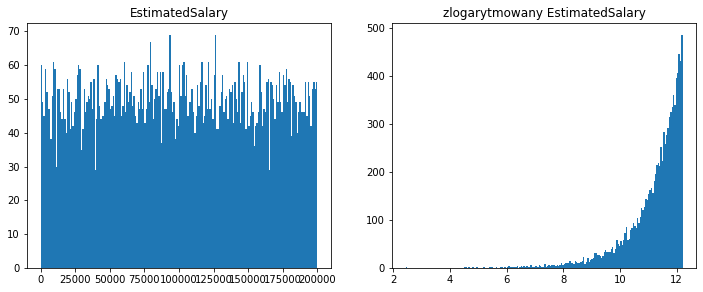

In [33]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.5))
ax[0].hist(df.EstimatedSalary, bins = 200)
ax[0].set_title('EstimatedSalary')
ax[1].hist(np.log(np.array(df.EstimatedSalary)), bins = 200)
ax[1].set_title('zlogarytmowany EstimatedSalary')
plt.show()

In [34]:
print('---Decyle EstimatedSalary---')
for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print('decyl {}: {}'.format(int(d*10), round(df.EstimatedSalary.quantile(q = d)), 2))
print('-'*20)
print('Min (niezaokrąglony): {}'.format(df.EstimatedSalary.min()))
print('-'*20)
print('Max (niezaokrąglony): {}'.format(df.EstimatedSalary.max()))
print('-'*20)

---Decyle EstimatedSalary---
decyl 1: 20274.0
decyl 2: 41051.0
decyl 3: 60736.0
decyl 4: 80238.0
decyl 5: 100194.0
decyl 6: 119710.0
decyl 7: 139432.0
decyl 8: 159837.0
decyl 9: 179675.0
decyl 10: 199992.0
--------------------
Min (niezaokrąglony): 11.58
--------------------
Max (niezaokrąglony): 199992.48
--------------------


In [35]:
# podział
df["EstimatedSalaryDec"] = pd.cut(df["EstimatedSalary"], 
       [0.0, 20274.0, 41051.0, 60736.0, 80238.0, 100194.0, 119710.0, 139432.0, 159837.0, 179675.0, 199993.0], 
       labels = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])

# tabela liczebności
salaryDecExited = pd.crosstab(df.EstimatedSalaryDec, df.Exited)

# prawdopodobienstwa
salaryDecExited['prob'] = salaryDecExited[1]/(salaryDecExited[1]+salaryDecExited[0])
salaryDecExited

Exited,0,1,prob
EstimatedSalaryDec,,,
D1,800,200,0.200
D2,801,199,0.199
D3,803,197,0.197
D4,798,202,0.202
D5,803,197,0.197
D6,793,207,0.207
D7,807,193,0.193
D8,789,211,0.211
D9,781,219,0.219


In [36]:
# import funkcji
from hpl import smart_log_var

# logarytmowanie
smart_log_var(df, 'EstimatedSalary')

In [37]:
# rozkład ketegorii logarytmów
df["LogEstimatedSalaryCut"] = pd.cut(df["EstimatedSalary_log"], 
       [0.0, 10.0, 11.0, 12.0, 13.0], 
       labels = ['0<x<10', '10<x<11', '11<x<12', 'x>12'])

# tablica liczebności
logSalaryDecExited = pd.crosstab(df.LogEstimatedSalaryCut, df.Exited)

# prawdopodobieństwa
logSalaryDecExited['prob'] = logSalaryDecExited[1]/(logSalaryDecExited[1]+logSalaryDecExited[0])
logSalaryDecExited

Exited,0,1,prob
LogEstimatedSalaryCut,,,
0<x<10,864,216,0.200000
10<x<11,1505,369,0.196905
11<x<12,4127,1047,0.202358
x>12,1467,405,0.216346


Kategoryzacja **EstimatedSalary i jego logarytmu nie przynosi rezultatów**. Należy zatem zostać tylko przy zmiennych ciągłych.<br/>
##### Zmienna Gender
 - zróżnicowanie płciowe obiektów pod względem prawdopodobieństwa churnu.

In [38]:
# tablica liczebności
genderExited = pd.crosstab(df.Gender, df.Exited)

# prawdopodobieństwa
genderExited['prob'] = genderExited[1]/(genderExited[1]+genderExited[0])
genderExited

Exited,0,1,prob
Gender,,,
Female,3404,1139,0.250715
Male,4559,898,0.164559


**Kobiety** mają wyraźnie **większe prawdopodbieństwo** churnu. Zmienna powinna być przydatna.
##### Zmienna Geography
 - zróżnicowanie geograficzne obiektów pod względem prawdopodobieństwa churnu.

In [40]:
# podział
geographyExited = pd.crosstab(df.Geography, df.Exited)

# prawdopodobieństwa
geographyExited['prob'] = geographyExited[1]/(geographyExited[1]+geographyExited[0])
geographyExited

Exited,0,1,prob
Geography,,,
France,4204,810,0.161548
Germany,1695,814,0.324432
Spain,2064,413,0.166734


**Niemcy** mają **dwukrotnie większe** prawdopodobieństwo churnu od reszty (Francuzi i Hiszpanie mają takie same prawdopodobieństwa).<br/>

##### numOfProducts
 - zróżnicowanie obiektów pod względem prawdopodobieństwa churnu przez liczbę posiadnych produktów.

In [41]:
# tablica liczebności
numOfProductsExited = pd.crosstab(df.NumOfProducts, df.Exited)

# prawdopodobieństwa
numOfProductsExited['prob'] = numOfProductsExited[1]/(numOfProductsExited[1]+numOfProductsExited[0])
numOfProductsExited

Exited,0,1,prob
NumOfProducts,,,
1,3675,1409,0.277144
2,4242,348,0.075817
3,46,220,0.827068
4,0,60,1.000000


Ciekawe, jeżeli ktoś ma **3 produkty to na 80% churn**, jak ktoś ma **4 produkty to zawsze churn**, co ciekawe jak ktoś ma **2 produkty to prawdopodobieństwo churnu jest 4x mniejsze niż jak ma 1 produkt**.
##### IsActiveMember
 - zróżnicowanie obiektów pod względem prawdopodobieństwa churnu przez aktywne członkostwo.

In [42]:
# tablica liczebności
IsActiveMemberExited = pd.crosstab(df.IsActiveMember, df.Exited)

# prawdopodobieństwa
IsActiveMemberExited['prob'] = IsActiveMemberExited[1]/(IsActiveMemberExited[1]+IsActiveMemberExited[0])
IsActiveMemberExited

Exited,0,1,prob
IsActiveMember,,,
0,3547,1302,0.268509
1,4416,735,0.142691


Jak ktoś **nie** jest **aktywnym** członkiem to odchodzi z **2 razy większym prawdopodobieństwem**.
##### HasCrCard
 - zróżnicowanie obiektów pod względem prawdopodobieństwa churnu przez posiadanie karty kredytowej.

In [43]:
# tablica liczebności
HasCrCardExited = pd.crosstab(df.HasCrCard, df.Exited)

# prawdopodobieństwa
HasCrCardExited['prob'] = HasCrCardExited[1]/(HasCrCardExited[1]+HasCrCardExited[0])
HasCrCardExited

Exited,0,1,prob
HasCrCard,,,
0,2332,613,0.208149
1,5631,1424,0.201843


posiadacze **karty kredytowej nie różnią się** prawdopodobieństwem churnu. Ta zmienna raczej w modelach nieopartych o drzewa losowe nie będzie pomagać. <br/>
##### Tenure
 - zróżnicowanie obiektów pod względem prawdopodobieństwa churnu w zależności od tego jak długo są klientami.

In [44]:
# tablica liczebności
tenureExited = pd.crosstab(df.Tenure, df.Exited)

# prawdopodobieństwa
tenureExited['prob'] = tenureExited[1]/(tenureExited[1]+tenureExited[0])
tenureExited

Exited,0,1,prob
Tenure,,,
0,318,95,0.230024
1,803,232,0.224155
2,847,201,0.191794
3,796,213,0.211100
4,786,203,0.205258
5,803,209,0.206522
6,771,196,0.202689
7,851,177,0.172179
8,828,197,0.192195


**Tenure nie** jest zbytnio **zróżnicowane** pod względem prawdopodobieństwa churnu, manipulacja tą zmienną nie powinna przynieść rezultatów.<br/>
##### CreditScore
 - podział na decyle,
 - znalezienie optymalnego/suboptymalnego podziału.

In [45]:
print(df.where(df.CreditScore == df.CreditScore.max()).Exited.dropna().value_counts())
print('Prawodpodobieństwo churnu jak max credit score: {}'.format(round(43/(190+43),4)))

0.0    190
1.0     43
Name: Exited, dtype: int64
Prawodpodobieństwo churnu jak max credit score: 0.1845


In [46]:
print('---Decyle CreditScore---')
for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print('decyl {}: {}'.format(int(d*10), round(df.CreditScore.quantile(q = d)), 2))
print('-'*20)
print('Min (niezaokrąglony): {}'.format(df.CreditScore.min()))
print('-'*20)
print('Max (niezaokrąglony): {}'.format(df.CreditScore.max()))
print('-'*20)

---Decyle CreditScore---
decyl 1: 521.0
decyl 2: 566.0
decyl 3: 599.0
decyl 4: 627.0
decyl 5: 652.0
decyl 6: 678.0
decyl 7: 704.0
decyl 8: 735.0
decyl 9: 778.0
decyl 10: 850.0
--------------------
Min (niezaokrąglony): 350
--------------------
Max (niezaokrąglony): 850
--------------------


In [47]:
# podział
df["CreditScoreDec"] = pd.cut(df["CreditScore"], 
       [0.0, 521.0, 566.0, 599.0, 627.0, 652.0, 678.0, 704.0, 735.0, 778.0, 851.0], 
       labels = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])

# tablica liczebności
creditScoreDecExited = pd.crosstab(df.CreditScoreDec, df.Exited)

# prawdopodobieństwa
creditScoreDecExited['prob'] = creditScoreDecExited[1]/(creditScoreDecExited[1]+creditScoreDecExited[0])
creditScoreDecExited

Exited,0,1,prob
CreditScoreDec,,,
D1,778,224,0.223553
D2,780,228,0.226190
D3,816,208,0.203125
D4,783,213,0.213855
D5,796,209,0.207960
D6,819,186,0.185075
D7,807,171,0.174847
D8,811,192,0.191426
D9,788,210,0.210421


Następujące po sobie decyle 6, 7 i 8 charakteryzują się podobnym, niższym od reszty (za wyjątkiem decyla 10) prawdopodobieństwem churnu, być może warto je zagregować.

In [48]:
# podział
df["CreditScoreDec678"] = pd.cut(df["CreditScore"], 
       [0.0, 521.0, 566.0, 599.0, 627.0, 652.0, 735.0, 778.0, 851.0], 
       labels = ['D1', 'D2', 'D3', 'D4', 'D5', 'D678', 'D9', 'D10'])

# tablica liczebności
creditScoreDec678Exited = pd.crosstab(df.CreditScoreDec678, df.Exited)

# prawdopodobieństwa
creditScoreDec678Exited['prob'] = creditScoreDec678Exited[1]/(creditScoreDec678Exited[1]+creditScoreDec678Exited[0])
creditScoreDec678Exited

Exited,0,1,prob
CreditScoreDec678,,,
D1,778,224,0.223553
D2,780,228,0.226190
D3,816,208,0.203125
D4,783,213,0.213855
D5,796,209,0.207960
D678,2437,549,0.183858
D9,788,210,0.210421
D10,785,196,0.199796


In [49]:
# podział
df["CreditScoreDec12"] = pd.cut(df["CreditScore"], 
       [0.0, 566.0, 599.0, 627.0, 652.0, 735.0, 778.0, 851.0], 
       labels = ['D12', 'D3', 'D4', 'D5', 'D678', 'D9', 'D10'])

# tablica liczebności
creditScoreDec12Exited = pd.crosstab(df.CreditScoreDec12, df.Exited)

# prawdopodobieństwa
creditScoreDec12Exited['prob'] = creditScoreDec12Exited[1]/(creditScoreDec12Exited[1]+creditScoreDec12Exited[0])
creditScoreDec12Exited

Exited,0,1,prob
CreditScoreDec12,,,
D12,1558,452,0.224876
D3,816,208,0.203125
D4,783,213,0.213855
D5,796,209,0.207960
D678,2437,549,0.183858
D9,788,210,0.210421
D10,785,196,0.199796


Agregacja pozostałych decyli - zbliżone prawdopodobieństwa.

In [50]:
# agregacja
CreditScoreFinalCut = df.CreditScoreDec12.copy().astype(str)
CreditScoreFinalCut = CreditScoreFinalCut.apply(lambda x: 'other' if x in ('D3', 'D4', 'D5', 'D9', 'D10') else x)
df['CSFC'] = CreditScoreFinalCut

# tablica liczebności
CSFCExited = pd.crosstab(df.CSFC, df.Exited)

# prawdopodobieństwa
CSFCExited['prob'] = CSFCExited[1]/(CSFCExited[1]+CSFCExited[0])
CSFCExited

Exited,0,1,prob
CSFC,,,
D12,1558,452,0.224876
D678,2437,549,0.183858
other,3968,1036,0.207034


Jak widać w decylach 678 występuje najniższe p. churnu, 4 p. procentowe więcej jest w decylach 1 i 2, reszta jest pomiędzy tymi wartościami.<br/>
Wyraźnie widać było podobieństwa Francuzów i Hiszpanów oraz zróżnicowanie obu tych grup względem Niemców, dlatego poniżej sprawdzone zostaną interkacje <br/>
#### Interakcje Geography i Balance,  EstimatedSalary, Age
 - podział danych na podzbiory geograficzne,
 - interakcje z Balance,
 - interakcje z EstimatedSalary,
 - interakcje z Age.

In [52]:
# podział zbioru danych na podzbiory geograficzne
dfGermany = df.where(df.Geography == 'Germany').dropna()
dfSpain = df.where(df.Geography == 'Spain').dropna()
dfFrance = df.where(df.Geography == 'France').dropna()

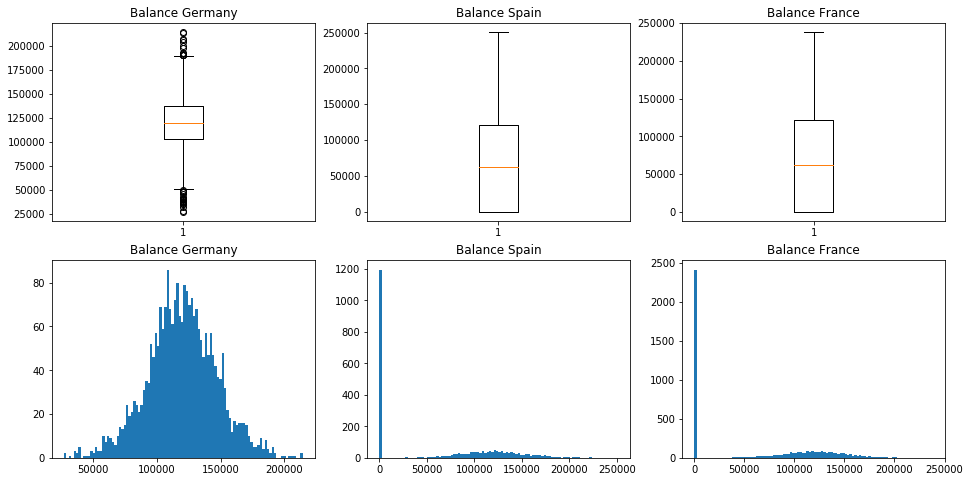

In [53]:
# Balance
rozmiar = (1,3)

f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))

ax[0,0].boxplot(dfGermany.Balance)
ax[1,0].hist(dfGermany.Balance, bins = 100)
ax[0,0].set_title('Balance Germany')
ax[1,0].set_title('Balance Germany')

ax[0,1].boxplot(dfSpain.Balance)
ax[1,1].hist(dfSpain.Balance, bins = 100)
ax[0,1].set_title('Balance Spain')
ax[1,1].set_title('Balance Spain')



ax[0,2].boxplot(dfFrance.Balance)
ax[1,2].hist(dfFrance.Balance, bins = 100)
ax[0,2].set_title('Balance France')
ax[1,2].set_title('Balance France')

plt.show()

In [54]:
print('Rozkłąd Niemców pod względem zerowości Balance: \n{}'.format(dfGermany.where(dfGermany.Balance == 0).Exited.dropna()))
print('\nRozkłąd Hiszpanów pod względem zerowości Balance: \n{}'.format(dfSpain.where(dfSpain.Balance == 0).Exited.dropna().value_counts()))
print('\nRozkłąd Francuzów pod względem zerowości Balance: \n{}'.format(dfFrance.where(dfFrance.Balance == 0).Exited.dropna().value_counts()))

Rozkłąd Niemców pod względem zerowości Balance: 
Series([], Name: Exited, dtype: float64)

Rozkłąd Hiszpanów pod względem zerowości Balance: 
0.0    1033
1.0     162
Name: Exited, dtype: int64

Rozkłąd Francuzów pod względem zerowości Balance: 
0.0    2078
1.0     336
Name: Exited, dtype: int64


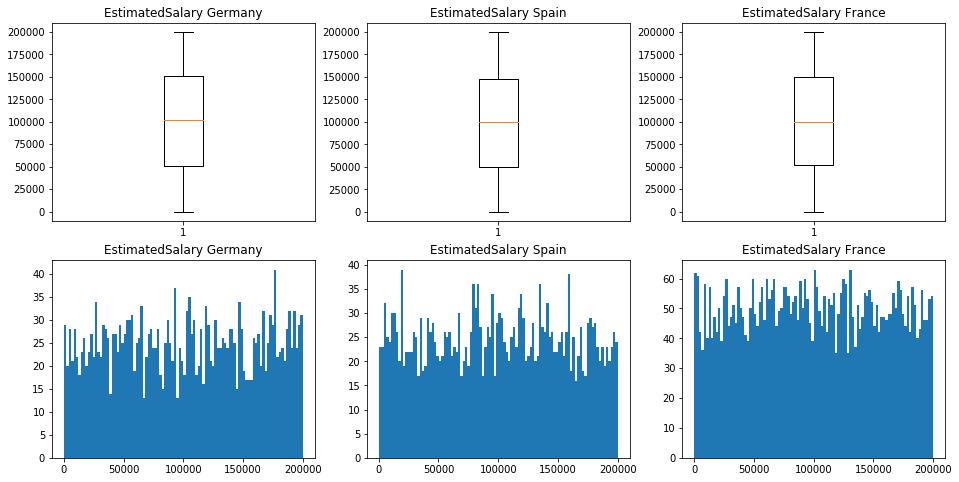

In [55]:
# EstimatedSalary
rozmiar = (1,3)

f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))

ax[0,0].boxplot(dfGermany.EstimatedSalary)
ax[1,0].hist(dfGermany.EstimatedSalary, bins = 100)
ax[0,0].set_title('EstimatedSalary Germany')
ax[1,0].set_title('EstimatedSalary Germany')

ax[0,1].boxplot(dfSpain.EstimatedSalary)
ax[1,1].hist(dfSpain.EstimatedSalary, bins = 100)
ax[0,1].set_title('EstimatedSalary Spain')
ax[1,1].set_title('EstimatedSalary Spain')



ax[0,2].boxplot(dfFrance.EstimatedSalary)
ax[1,2].hist(dfFrance.EstimatedSalary, bins = 100)
ax[0,2].set_title('EstimatedSalary France')
ax[1,2].set_title('EstimatedSalary France')

plt.show()

Z powyższej analizy wynika, że Kraje nie różnią się pod kątem zarobków, Niemcy nie mają przypadków z 0 Balance, Hiszpania i Francja nie różnią się pod kątem $P(y_i = 1|Balance = 0)$. Balance 0 było ważną cechą w predykcji Churnu, jednocześnie Niemcy mieli największe prawdopodobieństwo na churn, ciekawe czy jest inny czynnik.<br/>
Age

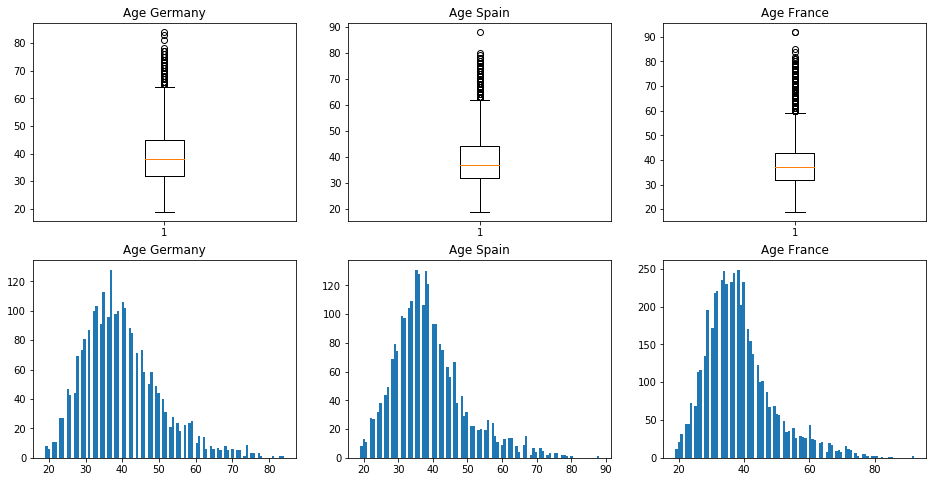

In [56]:
# Age
rozmiar = (1,3)

f, ax = plt.subplots(nrows = rozmiar[0]*2, ncols = rozmiar[1], figsize = (16, 8))

ax[0,0].boxplot(dfGermany.Age)
ax[1,0].hist(dfGermany.Age, bins = 100)
ax[0,0].set_title('Age Germany')
ax[1,0].set_title('Age Germany')

ax[0,1].boxplot(dfSpain.Age)
ax[1,1].hist(dfSpain.Age, bins = 100)
ax[0,1].set_title('Age Spain')
ax[1,1].set_title('Age Spain')



ax[0,2].boxplot(dfFrance.Age)
ax[1,2].hist(dfFrance.Age, bins = 100)
ax[0,2].set_title('Age France')
ax[1,2].set_title('Age France')

plt.show()

Interakcje optymalnych kategorii z krajami:
 - Niemcy,

In [57]:
# tabela liczebności
AgeCut35405065Germany = pd.crosstab(dfGermany.AgeCut35405065, dfGermany.Exited)

# prawdopodobieństwa
AgeCut35405065Germany['prob'] = AgeCut35405065Germany[1]/(AgeCut35405065Germany[1]+AgeCut35405065Germany[0])
AgeCut35405065Germany

Exited,0.0,1.0,prob
AgeCut35405065,,,
<35,806,135,0.143464
35<x<40,393,135,0.255682
40<x<50,347,331,0.488201
50<x<65,95,197,0.674658
>65,48,16,0.250000


 - Hiszpanie,

In [58]:
# tabela liczebności
AgeCut35405065Spain = pd.crosstab(dfSpain.AgeCut35405065, dfSpain.Exited)

# prawdopodobieństwa
AgeCut35405065Spain['prob'] = AgeCut35405065Spain[1]/(AgeCut35405065Spain[1]+AgeCut35405065Spain[0])
AgeCut35405065Spain

Exited,0.0,1.0,prob
AgeCut35405065,,,
<35,926,86,0.084980
35<x<40,520,58,0.100346
40<x<50,418,157,0.273043
50<x<65,136,104,0.433333
>65,60,7,0.104478


 - Francuzi.

In [59]:
# tabela liczebności
AgeCut35405065France = pd.crosstab(dfFrance.AgeCut35405065, dfFrance.Exited)

# prawdopodobieństwa
AgeCut35405065France['prob'] = AgeCut35405065France[1]/(AgeCut35405065France[1]+AgeCut35405065France[0])
AgeCut35405065France

Exited,0.0,1.0,prob
AgeCut35405065,,,
<35,2054,124,0.056933
35<x<40,1014,146,0.125862
40<x<50,767,300,0.281162
50<x<65,238,227,0.488172
>65,121,12,0.090226


Francuzi i Hiszpanie są dość podobni, Niemcy dużo więcej w każdej grupie wiekowej, zatem przydatna może być **interakcja kategorii wieku z Germany**.
##### Korelacja zmiennych ciągłych (Spearman - zmienne nie mają rozkładów normalnych, pominięto obserwacje z zerowym Balance).

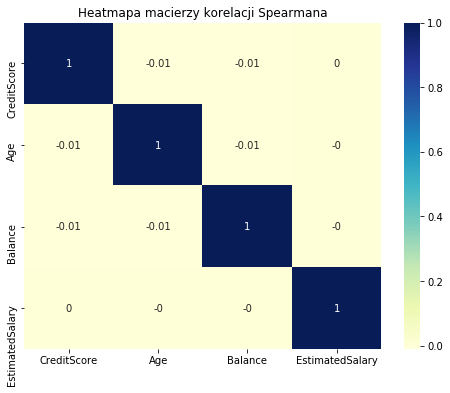

In [60]:
plt.figure(figsize=(8,6))

correl = np.round(df.where(df.Balance >0).dropna()[num].corr(method = 'spearman'), 2)
sns.heatmap(correl, cmap="YlGnBu", annot=True, cbar=True)
plt.title('Heatmapa macierzy korelacji Spearmana')
plt.show()

Zmienne wybinie nieskorelowane ze sobą, brak problemu współliniowości (obcięcie Zalance w zerze zmniejszyło jej korelację z Age o 0.02).
###### Test na równość średnich zmiennych ciągłych.

In [61]:
# import funkcji
from hpl import popMeanTest

# podział na "1" i "0"
poszli = df.where(df.Exited == 1).dropna()
zostali = df.where(df.Exited == 0).dropna()


# listy, w których będą zapisane wyniki
stats = []
critics = []
pvals = []
atr = []

for n in num:
    # testowanie
    s, crt, p = popMeanTest(np.array(poszli[n]), np.array(zostali[n]), alternative='two-sided')
    # zapisanie wyników
    stats.append(s)
    critics.append(crt)
    pvals.append(round(p, 5))
    atr.append(n)
    
# zapisanie wyników do obiektu DataFrame
srednie = pd.DataFrame(data = {"zmienna":atr, "U":stats, "wartość krytyczna":critics, "p_value":pvals})

display(srednie)

,zmienna,U,wartość krytyczna,p_value
0,CreditScore,-2.599588,1.959964,0.00933
1,Age,30.412782,1.959964,0.00000
2,Balance,12.557689,1.959964,0.00000
3,EstimatedSalary,1.211748,1.959964,0.22561


"1" i "0" są zróżnicowane pod względem zmiennych ciągłych, za wyjątkiem EstimatedSalary (Rozkład zbliżony do jednostajnego), być może ta zmienna okaże się nieprzydatna.<br/>
Szykowanie zbioru danych do algorytmów (uwzględnienie wniosków powyższych analiz).

In [62]:
df_o = df.copy()

# df z feature engeeiringu
df_o.drop(['BalanceCut', 'AgeCut', 'AgeCut35', 'AgeCut40', 'AgeCut50', 'AgeCut60', 'AgeCut4060',
         'AgeCut4065', 'AgeCut3565', 'AgeCut354065', 'EstimatedSalaryDec', 'LogEstimatedSalaryCut', 'CreditScoreDec',
         'CreditScoreDec678', 'CreditScoreDec12', 'HasCrCard'], axis = 1, inplace = True)

# dodanie logarytmu Age
smart_log_var(df_o, 'Age')

# binaryzacja
df_o = pd.get_dummies(df_o, columns = ['Geography', 'Gender', 'NumOfProducts', 'BalanceCutZero', 'AgeCut35405065', 'CSFC'],
                      drop_first = False)
df_o.drop(['CSFC_D678', 'Geography_France', 'Geography_Spain', 'Gender_Male', 'BalanceCutZero_zero', 'AgeCut35405065_<35',
          'NumOfProducts_2'], axis = 1, inplace = True)

In [63]:
# zmiana nazw kolumn nowego df (kwestie techniczne)
df_o.rename(mapper = {
    'CreditScore' : 'CreditScore',
     'Age' : 'Age',
     'Tenure' : 'Tenure',
     'Balance' : 'Balance',
     'IsActiveMember' : 'IsActiveMember',
     'EstimatedSalary' : 'EstimatedSalary',
     'Exited' : 'Exited',
     'Geography_Germany' : 'GeographyGermany',
     'Gender_Female' : 'GenderFemale',
     'NumOfProducts_1' : 'NumOfProducts1',
     'NumOfProducts_3' : 'NumOfProducts3',
     'NumOfProducts_4' : 'NumOfProducts4',
     'BalanceCutZero_notZero' : 'BalancePositive',
     'AgeCut35405065_35<x<40' : 'AgeFrom35To40',
     'AgeCut35405065_40<x<50' : 'AgeFrom40To50',
     'AgeCut35405065_50<x<65' : 'AgeFrom50To65',
     'AgeCut35405065_>65' : 'AgeHigherThan65', 
     'CSFC_D12' : 'CreditScoreDeciles1and2', 
     'CSFC_other' : 'CreditScoreDeciles3459and10',
     'EstimatedSalary_log' : 'EstimatedSalarylog',
     'Age_log' : 'Agelog'
    }, axis = 1, inplace = True)

# lista cech po inżynierii
features_eng = df_o.columns.tolist()

In [64]:
# oryginalny df jako alternatywa
df = pd.read_csv("Churn_Modelling.csv")
df.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [70]:
from sklearn import preprocessing # label encoding
import statsmodels.api as sm # do logitu
from sklearn.model_selection import train_test_split # podział na zbiory treningowe i testowe
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score # metryki
from sklearn.model_selection import KFold # walidacja K-składana
from sklearn.model_selection import StratifiedKFold # warstowa walidacja K-składana
from sklearn.svm import SVC # estymator SVM
from sklearn import neighbors # estymator KNN
from sklearn.ensemble import RandomForestClassifier # estymator RF
import pickle

In [65]:
def CVTest(dataframe, clf = "logit", nFolds = 5, randomState=2020, y = 'Exited', features = [],
           report = None, imbalanced = True, sample_size = 5000, *args, **kwargs):
    
    # Podzielenie zbioru na foldy
    if imbalanced:
        kf = StratifiedKFold(n_splits = nFolds, shuffle = True, random_state = randomState)
    else:
        kf = KFold(n_splits = nFolds, shuffle = True, random_state = randomState)

    # Stworzenie list z wynikami
    ROCtestResults = []
    PRtestResutls = []
    ROCtrainResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(dataframe.index.values, dataframe[y]):
        # Stworzenie modelu
        # ---LOGIT---
        if clf == "logit":
            mod = sm.GLM.from_formula(formula = y + '~' + '+'.join(features), data = dataframe.iloc[train],
                                      family = sm.families.Binomial())
            # Estymacja
            res = mod.fit()
            # Zapisanie predykcji
            predsTrain = res.predict()
            preds = res.predict(dataframe.iloc[test])
        # ---SVM---
        elif clf == 'SVM':
            clf = SVC(probability=True, max_iter=-1, tol=0.001, cache_size=500, *args, **kwargs)
            
            # Zmniejszenie zbioru treningowego
            sampleSize = sample_size
            X = dataframe.iloc[train].sample(sampleSize)
            # Trenowanie modelu
            clf.fit(X[features], X['Exited'])
            # Prognozy dla zbioru treningowego i testowego
            predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
            preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]
        #---KNN---
        elif clf == 'KNN':
            clf = neighbors.KNeighborsClassifier(*args, **kwargs)
            
            # Trenowanie modelu
            clf.fit(dataframe.iloc[train][features], dataframe.iloc[train][y])
            # Prognozy dla zbioru treningowego i testowego
            predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
            preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]


        if report == "full":
            train_y = dataframe[y].loc[train]
            test_y = dataframe[y].loc[test]
            print("0 in y_train = {}, 1 in y_train = {} \n0 in y_test = {}, 1 in y_test = {}".format(
            len(train_y[train_y == 0]), len(train_y[train_y == 1]), len(test_y[test_y == 0]), 
            len(test_y[test_y == 1])))
        
        elif report == "half":
            print("Train AUC-ROC:", roc_auc_score(dataframe[y].iloc[train], predsTrain), 
              "Valid AUC-ROC:", roc_auc_score(dataframe[y].iloc[test], preds), 
                 "\nTrain AUC-PR:", average_precision_score(dataframe[y].iloc[train], predsTrain), 
                  "Valid AUC-PR:", average_precision_score(dataframe[y].iloc[test], preds),
                 '\n'+'-'*40)
        else:
            pass

        # Zapisanie wyników ze zbioru walidacyjnego do list
        ROCtestResults.append(roc_auc_score(dataframe[y].iloc[test], preds))
        PRtestResutls.append(average_precision_score(dataframe[y].iloc[test], preds))
        ROCtrainResults.append(roc_auc_score(dataframe[y].iloc[train], predsTrain))
        PRtrainResults.append(average_precision_score(dataframe[y].iloc[train], predsTrain))
        predictions.append(preds.tolist().copy())
        indices.append(dataframe.iloc[test].index.tolist().copy())

    # zwrot list
    return ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices

In [68]:
# przygotowanie zmiennych
features_eng.remove('EstimatedSalary')
features_eng.remove('Age')
features_eng.remove('Exited')

In [71]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report='half')

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

Train AUC-ROC: 0.849539122707164 Valid AUC-ROC: 0.843240405458666 
Train AUC-PR: 0.6694223240357228 Valid AUC-PR: 0.6574637700456246 
----------------------------------------
Train AUC-ROC: 0.8482459510217366 Valid AUC-ROC: 0.8478221376490296 
Train AUC-PR: 0.6665788521387447 Valid AUC-PR: 0.6762438734291687 
----------------------------------------
Train AUC-ROC: 0.8466546599763076 Valid AUC-ROC: 0.8538199216165318 
Train AUC-PR: 0.6716150644671515 Valid AUC-PR: 0.6562685975814674 
----------------------------------------
Train AUC-ROC: 0.8521593743679634 Valid AUC-ROC: 0.831076068364204 
Train AUC-PR: 0.6729665027383102 Valid AUC-PR: 0.6524599374588075 
----------------------------------------
Train AUC-ROC: 0.8460286426982307 Valid AUC-ROC: 0.8567751110123992 
Train AUC-PR: 0.6625920592732918 Valid AUC-PR: 0.6881812435503473 
----------------------------------------
------------------------------
ROC: 0.8465467288201662
PR: 0.666123484413083
ROCtrain-test: 0.0019788213341143113
PRtr

**Po zastosowaniu inżynierii zmiennych Logit osiągnął wyniki zbliżone do Random Forest! Wzrost ROC o ok 0.08, i wzrost PR o 0.2**<br/>
Poniżej eksperymenty z logarytmami zmiennych EstimatedSalary i Age.

In [73]:
features_eng = df_o.columns.tolist()
#features_eng.remove('EstimatedSalary')
#features_eng.remove('Age')
features_eng.remove('EstimatedSalarylog')
features_eng.remove('Agelog')
features_eng.remove('Exited')

In [74]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8465644594097803
PR: 0.6658120441294217
ROCtrain-test: 0.0020014069083507113
PRtrain-test: 0.0023396939244210158


In [75]:
features_eng = df_o.columns.tolist()
features_eng.remove('EstimatedSalary')
#features_eng.remove('Age')
#features_eng.remove('EstimatedSalarylog')
features_eng.remove('Agelog')
features_eng.remove('Exited')

In [76]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.846499570431512
PR: 0.6655484504434349
ROCtrain-test: 0.0020197918290901784
PRtrain-test: 0.0024717100541304937


In [77]:
features_eng = df_o.columns.tolist()
#features_eng.remove('EstimatedSalary')
features_eng.remove('Age')
features_eng.remove('EstimatedSalarylog')
#features_eng.remove('Agelog')
features_eng.remove('Exited')

In [78]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8465857424885022
PR: 0.6663550272471861
ROCtrain-test: 0.0019807986884212703
PRtrain-test: 0.002413159985944935


Najlepsze rezultaty logit uzyskał na logarytmie Age i nominalnej EstimatedSalary.<br/>
##### normalizacja zmiennych i logit

In [80]:
# normalizacja zmiennych ciągłych
    # zbiór opracowany
fornorm = ['CreditScore', 'Balance', 'EstimatedSalary', 'Agelog']
df_o[fornorm] = df_o[fornorm].apply(lambda x: (x-x.mean())/x.std())
    # zbiór podstawowy
df[['CreditScore', 'Balance', 'EstimatedSalary', 'Age']] = df[['CreditScore', 'Balance', 'EstimatedSalary', 'Age']].apply(lambda x: (x-x.mean())/x.std())

# unitaryzacja zmiennej uporządkowanej
    # zbiór ze opracowany
df_o.Tenure = df_o['Tenure'].apply(lambda x: (x-df_o.Tenure.min())/(df_o.Tenure.max()-df_o.Tenure.min()))
    # zbiór podstawowy
df.Tenure = df['Tenure'].apply(lambda x: (x-df.Tenure.min())/(df.Tenure.max()-df.Tenure.min()))

In [81]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8465857424885022
PR: 0.6663550272471861
ROCtrain-test: 0.0019807986884212703
PRtrain-test: 0.002413159985944935


Na logicie nie widać zmian, ale taki dataframe może się przydać w przypadku SVM, KNN i sieci neuronowych. <br/>
##### Dalszy ciąg inżynierii zmiennych, usuwanie niepotrzebnych.

In [82]:
from sklearn import feature_selection
from scipy.stats import spearmanr

In [83]:
# zmienne do zbadania
zmienne = df_o.columns.tolist()
zmienne.remove('Exited')
zmienne.remove('Age')
zmienne.remove('EstimatedSalarylog')

# obliczenia - Mutual Information i Korelacja Spearmana
wyniki = pd.DataFrame(data = np.ones((len(zmienne), 4)),
                      columns = ['zmienna', 'Mutual information', 'Spearman', 'p_value (Spearman)'])

i = 0
for z in zmienne:
    mi = feature_selection.mutual_info_classif((df_o[z].values).reshape(-1, 1),
                                                  df_o.Exited.values, random_state=2020)
    corr, p = spearmanr(df_o[z].values, df_o.Exited.values)
    
    wyniki.iloc[i, :] = (z, mi, corr, round(p, 4)) 
    i += 1
    
# sortowanie wyników
wyniki.sort_values(by = 'Mutual information', ascending = False)

,zmienna,Mutual information,Spearman,p_value (Spearman)
5,Agelog,0.076583,0.323968,0.0000
14,AgeFrom50To65,0.035022,0.269271,0.0000
9,NumOfProducts3,0.026960,0.255862,0.0000
13,AgeFrom40To50,0.018729,0.185535,0.0000
3,IsActiveMember,0.014743,-0.156128,0.0000
6,GeographyGermany,0.013674,0.173488,0.0000
8,NumOfProducts1,0.012876,0.185447,0.0000
10,NumOfProducts4,0.012275,0.153612,0.0000
2,Balance,0.006229,0.111110,0.0000
11,BalancePositive,0.005898,0.122357,0.0000


Zaczynamy od końca

In [84]:
features_eng = zmienne.copy()

features_eng.remove('CreditScoreDeciles3459and10')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng, 
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8466135789516779
PR: 0.6664233465519849
ROCtrain-test: 0.0018453923899609537
PRtrain-test: 0.002174942609470931


In [85]:
features_eng.remove('Tenure')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8466134044913722
PR: 0.6665537712724896
ROCtrain-test: 0.0017541854609013363
PRtrain-test: 0.0018273610505467053


In [86]:
features_eng.remove('CreditScore')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8466337143095499
PR: 0.6666501918551475
ROCtrain-test: 0.0017264964132417404
PRtrain-test: 0.0017247877300246017


In [87]:
features_eng.remove('CreditScoreDeciles1and2')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8464325576579738
PR: 0.6664518031210973
ROCtrain-test: 0.0015854707241743649
PRtrain-test: 0.0015942733233371698


In [88]:
features_eng.append('CreditScoreDeciles1and2')
features_eng.remove('EstimatedSalary')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8467507951604656
PR: 0.6664997053505026
ROCtrain-test: 0.0015288214947885015
PRtrain-test: 0.0016680533083822668


In [89]:
features_eng.append('EstimatedSalary')
features_eng.remove('AgeFrom35To40')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8461963897067977
PR: 0.6668525917091397
ROCtrain-test: 0.0016853455480440038
PRtrain-test: 0.001614709273122461


In [90]:
features_eng.remove('GenderFemale')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8411286756182189
PR: 0.6628222729488236
ROCtrain-test: 0.0016293982876209867
PRtrain-test: 0.001863175926227978


In [91]:
features_eng.append('GenderFemale')
features_eng.remove('BalancePositive')
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.846096661638134
PR: 0.6659831360265013
ROCtrain-test: 0.0016233443844009265
PRtrain-test: 0.0015099158087299447


In [92]:
features_eng.append('BalancePositive')

Z poprzednich symulacji wiem, że zmienna Tenure może jednak dodać wartość do modelu, poniżej sprawdzenie.

In [93]:
features_eng.append('Tenure')
ROCtestResults1, PRtestResults1, ROCtrainResults1, PRtrainResults1, predictions, indices = CVTest(dataframe = df_o, features = features_eng)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults1),
    np.mean(PRtestResults1), 
    np.mean(ROCtrainResults1)-np.mean(ROCtestResults1),
    np.mean(PRtrainResults1)-np.mean(PRtestResults1)))

------------------------------
ROC: 0.8463103266804287
PR: 0.667014370343572
ROCtrain-test: 0.0017284258941002717
PRtrain-test: 0.0017668538674863177


Jak widać powyżej ponowne dodanie Tenure do zbioru zmiennych objaśniających zwiększyło jakość modelu.
Z uwagi na duże spadki, nie ma sensu dalej sprawdzać.<br/>
Podsumowując, odpadły zmienne:
 - CreditScoreDeciles3459and10
 - CreditScore
 - AgeFrom35To40

Zatem aktualny model to:

In [95]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df_o,
                                                                                              features = features_eng,
                                                                                              report=False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('{}\nzmienne:\n'.format('-'*30), features_eng)

------------------------------
ROC: 0.8463103266804287
PR: 0.667014370343572
ROCtrain-test: 0.0017284258941002717
PRtrain-test: 0.0017668538674863177
------------------------------
zmienne:
 ['Balance', 'IsActiveMember', 'Agelog', 'GeographyGermany', 'NumOfProducts1', 'NumOfProducts3', 'NumOfProducts4', 'AgeFrom40To50', 'AgeFrom50To65', 'AgeHigherThan65', 'CreditScoreDeciles1and2', 'EstimatedSalary', 'GenderFemale', 'BalancePositive', 'Tenure']


##### Zapisanie finalnego Data Frame i logitu na zmiennych z inżynierii po selekcji.

In [98]:
# zapisanie finalnego dataframe
ftr = features_eng.copy()
ftr.append('Exited')
dffin = df_o[ftr].copy()

In [97]:
# zapis modelu
model_logit_01 = {
    "name":"model_logit_01",
    "description":"Model Logitowy po inżynierii zmiennych i selekcji",
    "specification":', bez regularyzacji',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_eng.copy()
}

zapis_model_logit_01 = False

if zapis_model_logit_01:
    with open("model_logit_01.p", "wb") as fp:
        pickle.dump(model_logit_01, fp)

Dodanie regularyzacji do najlepszego jak dotąd logitu.
##### Lasso, Ridge

In [99]:
from sklearn import linear_model

In [100]:
def CVTestLinearClass(df=dffin, nFolds = 5, randomState=2020, report=False,
                      features=features_eng, saveModels = False, target = 'Exited',
                      *args, **kwargs):
    # warstwowa walidacja krzyżowa
    kf = StratifiedKFold(n_splits = nFolds, shuffle = True, random_state = randomState)

    # listy do zapisywania wyników:
    ROCtestResults = []
    PRtestResutls = []
    ROCtrainResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    models = []
    
    for train, test in kf.split(df.index.values, df[target]):

        # Przygotowanie estymatora
        clf = linear_model.LogisticRegression(*args, **kwargs)
        
        if report:
            print(clf)
        
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # prognozy
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # zapisanie predykcji i indeksów
        predictions.append(preds.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Obliczenie metryk
        ROCtrainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        ROCtestScore = roc_auc_score(df[target].iloc[test], preds)
        PRtrainScore = average_precision_score(df[target].iloc[train], predsTrain)
        PRtestScore = average_precision_score(df[target].iloc[test], preds)
        
        # zapisane metryk
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        if report:
            print("Train AUC-ROC:",ROCtrainScore , 
              "Valid AUC-ROC:", ROCtestScore, 
                 "\nTrain AUC-PR:", PRtrainScore, 
                  "Valid AUC-PR:", PRtestScore,
                 '\n'+'-'*40)
        if saveModels:
            models.append(clf)
        
    return ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices, models

Sprawdzenie, czy bez regularyzacji wyniki będą te same.

In [102]:
ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices, models = CVTestLinearClass(
    df = dffin, features = features_eng, penalty = 'none', max_iter = 2000)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('{}\nzmienne:\n'.format('-'*30), features_eng)

------------------------------
ROC: 0.8463177233243606
PR: 0.6670235366339763
ROCtrain-test: 0.001721607367448641
PRtrain-test: 0.0017606864142979406
------------------------------
zmienne:
 ['Balance', 'IsActiveMember', 'Agelog', 'GeographyGermany', 'NumOfProducts1', 'NumOfProducts3', 'NumOfProducts4', 'AgeFrom40To50', 'AgeFrom50To65', 'AgeHigherThan65', 'CreditScoreDeciles1and2', 'EstimatedSalary', 'GenderFemale', 'BalancePositive', 'Tenure']


Różnice są pomijalne.

In [103]:
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5]:
    ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices, models = CVTestLinearClass(
        df = dffin, features = features_eng, penalty = 'l1', solver="liblinear", C=c, max_iter = 2000)
    
    print('{}\nC: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30, c,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
C: 0.01
ROC: 0.7886310441350645
PR: 0.6204947190044322
ROCtrain-test: 0.0019812137053897283
PRtrain-test: -0.09351875663363585
------------------------------
C: 0.1
ROC: 0.8451898820831752
PR: 0.6310501831476341
ROCtrain-test: 0.0017590523664635649
PRtrain-test: 0.03364534309344702
------------------------------
C: 0.25
ROC: 0.8460510940225691
PR: 0.6380014669267843
ROCtrain-test: 0.0017797617018963097
PRtrain-test: 0.02985255213150695
------------------------------
C: 0.5
ROC: 0.8461898081094981
PR: 0.6427575757837716
ROCtrain-test: 0.001778143748149219
PRtrain-test: 0.025758837932476464
------------------------------
C: 1
ROC: 0.8462406642573429
PR: 0.6461880426175037
ROCtrain-test: 0.001774777798273619
PRtrain-test: 0.022550119615105557
------------------------------
C: 2
ROC: 0.8462699462976113
PR: 0.6487792255174321
ROCtrain-test: 0.0017586351471745587
PRtrain-test: 0.020007316684881427
------------------------------
C: 5
ROC: 0.8463001554508598
PR: 

In [104]:
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 50, 100]:
    ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices, models = CVTestLinearClass(
        df = dffin, features = features_eng, penalty = 'l2', C=c, max_iter = 2000)
    
    print('{}\nC: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30, c,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
C: 0.01
ROC: 0.8224323687185885
PR: 0.6457828049910259
ROCtrain-test: 0.0016603448503655915
PRtrain-test: -0.04409676031293075
------------------------------
C: 0.1
ROC: 0.8436282733046336
PR: 0.6465672401032438
ROCtrain-test: 0.001656616075075612
PRtrain-test: 0.009270615726892473
------------------------------
C: 0.25
ROC: 0.8456408217889948
PR: 0.647843686059929
ROCtrain-test: 0.0016493249546222222
PRtrain-test: 0.015521983187798516
------------------------------
C: 0.5
ROC: 0.8461173407109156
PR: 0.6491117957815151
ROCtrain-test: 0.0016857330722076513
PRtrain-test: 0.017000157781030367
------------------------------
C: 1
ROC: 0.846223064305657
PR: 0.6502922630315345
ROCtrain-test: 0.0017438850884193835
PRtrain-test: 0.017260797104943326
------------------------------
C: 2
ROC: 0.846287214137855
PR: 0.6513670016337656
ROCtrain-test: 0.0017364742043742831
PRtrain-test: 0.016937737613108572
------------------------------
C: 5
ROC: 0.8463087966870588
PR: 

Powyższe eksperymenty wykazują wyższość logitu z brakiem regularyzacji nad Lasso i Ridge (co jest logiczne - przetrenowanie jest niewielkie).
##### SVM

In [105]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(
    clf = 'SVM', dataframe = dffin, features = features_eng, kernel = 'linear')

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.5651581630280585
PR: 0.2917624312163808
ROCtrain-test: 0.006055964160837646
PRtrain-test: 0.004160403009866753


In [107]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(
    clf = 'SVM', dataframe = dffin, features = features_eng, kernel = 'rbf')

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.5575871828087621
PR: 0.2939133529821448
ROCtrain-test: 0.017296907385943472
PRtrain-test: 0.01376294548134982


Wyniki mizerne w porównaniu do dotychczasowych alorytmów, może zmiana ważenia klas przyniesie jakiś rezultat.

In [108]:
for w in [{0:1.0, 1:4.0}, {0:1.0, 1:3.9}, {0:1.0, 1:2.0}]:
    ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(
    clf = 'SVM', dataframe = dffin, features = features_eng, kernel = 'rbf', class_weight = w)

    print('{}\nwagi: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30, w,
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
wagi: {0: 1.0, 1: 4.0}
ROC: 0.5667772043977207
PR: 0.2978853624550959
ROCtrain-test: 0.011414113518733116
PRtrain-test: 0.008074938087670347
------------------------------
wagi: {0: 1.0, 1: 3.9}
ROC: 0.5651458691287697
PR: 0.2912689397878253
ROCtrain-test: 0.01237267985298185
PRtrain-test: 0.012694966289502008
------------------------------
wagi: {0: 1.0, 1: 2.0}
ROC: 0.5639749699828884
PR: 0.2990583608764026
ROCtrain-test: 0.017082161929244943
PRtrain-test: 0.009596655152266598


SVM zdecydowanie nie radzi sobie z tym problemem, nie ma sensu się nim zajmować dalej.
##### KNN

In [109]:
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(
    clf = 'KNN', dataframe = dffin, features = features_eng, n_jobs = -1, p = 2, n_neighbors = k)
    
    print('{}\nsąsiedzi: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30, k,
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
sąsiedzi: 1
ROC: 0.5321673149898274
PR: 0.22924498908434005
ROCtrain-test: 0.07419615540876623
PRtrain-test: 0.13600618665970649
------------------------------
sąsiedzi: 3
ROC: 0.5508571797742055
PR: 0.25759443018779266
ROCtrain-test: 0.04482969414721183
PRtrain-test: 0.06108141375428344
------------------------------
sąsiedzi: 5
ROC: 0.5579350878746034
PR: 0.2664361296841909
ROCtrain-test: 0.031075614453134226
PRtrain-test: 0.042176202744964864
------------------------------
sąsiedzi: 10
ROC: 0.5648924703316255
PR: 0.2735200408345599
ROCtrain-test: 0.01791839602698675
PRtrain-test: 0.02542878855201175
------------------------------
sąsiedzi: 15
ROC: 0.566343170585782
PR: 0.2783144684586508
ROCtrain-test: 0.012702666952256636
PRtrain-test: 0.01816003113974607
------------------------------
sąsiedzi: 30
ROC: 0.5679808511092533
PR: 0.2844772989309009
ROCtrain-test: 0.009889994765569843
PRtrain-test: 0.009660032331969381
------------------------------
sąsied

KNN podobnie jak SVM, nie nadaje się do tego problemu.
##### Sprawdzenie, czy nowe zmienne pomogą w XGB

In [111]:
from random import shuffle
from random import randint
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

In [112]:
def run_xgb(train, validate, features = features_eng, target = 'Exited', # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc", "aucpr"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja

   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
        
    if (debug and debug != 'half'):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenia statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do obiektu DataFrame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla ważności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig = None
    if debug:
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej ważnośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
        
    return score, trainPred, testPred, train_history, impFig, imp

In [113]:
test_size = 0.2
X_train, X_valid = train_test_split(dffin, test_size=test_size, random_state=2017, stratify=df['Exited'].values)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc', 'aucpr'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 8000
Length valid: 2000
[0]	train-auc:0.755622	train-aucpr:0.542796	valid-auc:0.713307	valid-aucpr:0.436347
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[1]	train-auc:0.822652	train-aucpr:0.636639	valid-auc:0.776315	valid-aucpr:0.519716
[2]	train-auc:0.855214	train-aucpr:0.698728	valid-auc:0.82577	valid-aucpr:0.606725
[3]	train-auc:0.861516	train-aucpr:0.713701	valid-auc:0.822723	valid-aucpr:0.61758
[4]	train-auc:0.859767	train-aucpr:0.713545	valid-auc:0.820393	valid-aucpr:0.617294
[5]	train-auc:0.863018	train-aucpr:0.721702	valid-auc:0.821551

[91]	train-auc:0.918945	train-aucpr:0.807184	valid-auc:0.860633	valid-aucpr:0.684981
[92]	train-auc:0.919189	train-aucpr:0.807676	valid-auc:0.860572	valid-aucpr:0.685109
[93]	train-auc:0.91992	train-aucpr:0.808938	valid-auc:0.860166	valid-aucpr:0.68465
[94]	train-auc:0.9202	train-aucpr:0.809475	valid-auc:0.86014	valid-aucpr:0.685196
[95]	train-auc:0.920521	train-aucpr:0.810289	valid-auc:0.859802	valid-aucpr:0.684034
[96]	train-auc:0.920842	train-aucpr:0.810574	valid-auc:0.85968	valid-aucpr:0.684399
[97]	train-auc:0.920964	train-aucpr:0.810907	valid-auc:0.859498	valid-aucpr:0.684455
[98]	train-auc:0.921324	train-aucpr:0.81146	valid-auc:0.859589	valid-aucpr:0.684735
[99]	train-auc:0.921789	train-aucpr:0.812392	valid-auc:0.859699	valid-aucpr:0.684337
[100]	train-auc:0.922416	train-aucpr:0.813595	valid-auc:0.859662	valid-aucpr:0.684272
[101]	train-auc:0.922488	train-aucpr:0.813708	valid-auc:0.859594	valid-aucpr:0.684416
[102]	train-auc:0.923062	train-aucpr:0.81453	valid-auc:0.859483	valid-

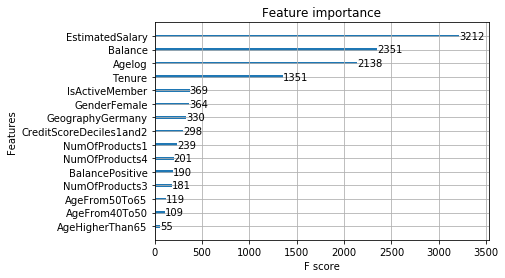

In [114]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, 'Exited', early_stopping_rounds=50, debug = True)

wyniki odrobinę gorsze, warto przeprowadzić analizę hiperparametrów.
 - głębokość drzew,

5 0.691091
6 0.690528
7 0.685581
8 0.684123
9 0.680434
10 0.675203


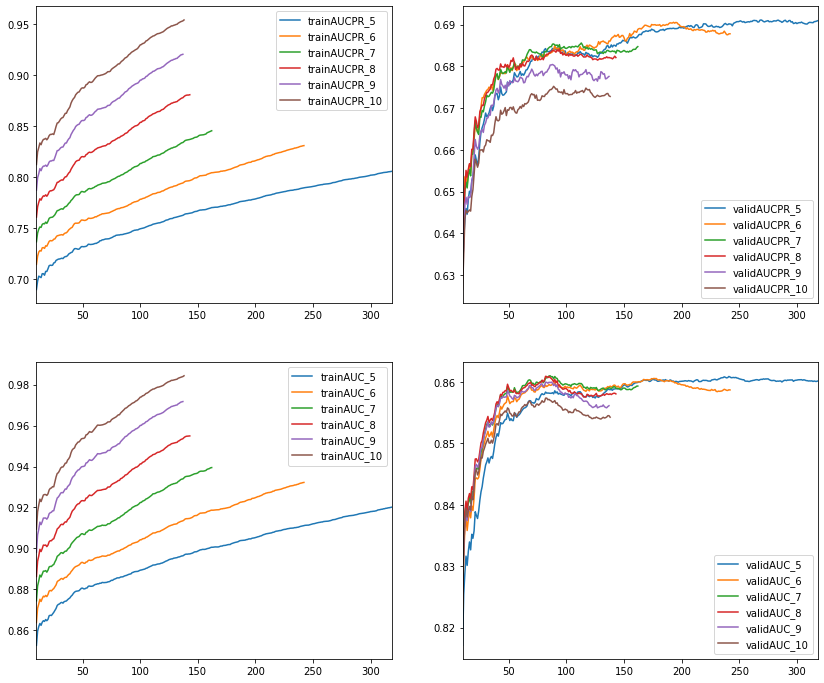

In [116]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(5,11,1)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, 'Exited',
                                                                     max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

Najlepsze wyniki na głębokości 5-6, na tym foldzie lepsze wyniki i mniejsze przetrenowanie na 5, ale może warto sprawdzić też płytsze drzewa.

1 0.661204
2 0.686678
3 0.690277
4 0.690361
5 0.691091


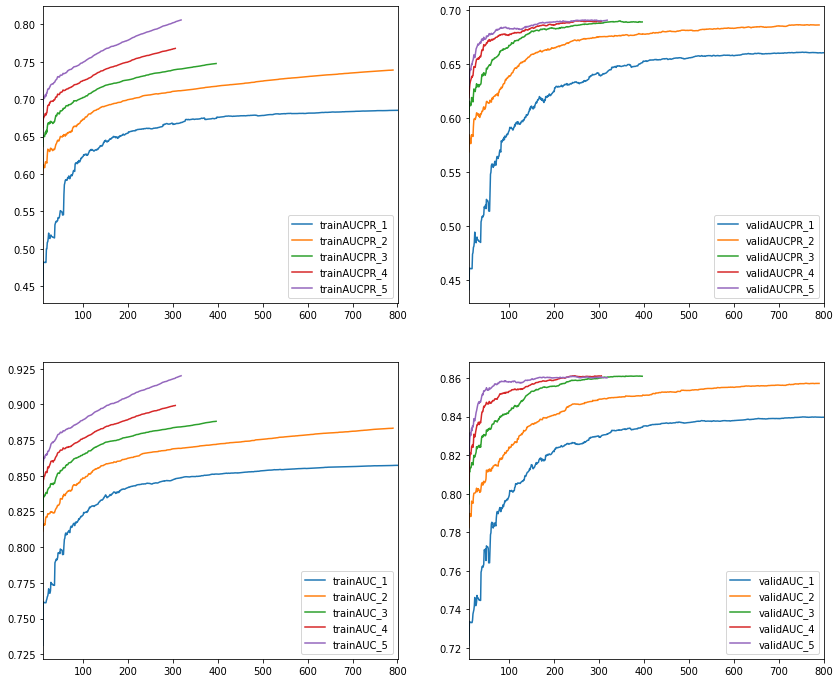

In [117]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(1,6,1)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, 'Exited',
                                                                     max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

zakres 5-6, testy na 5.
 - udział wierszy,

0.3 0.687782
0.4 0.68775
0.5 0.689865
0.6 0.690601
0.7 0.691091
0.8 0.691924
0.9 0.693032


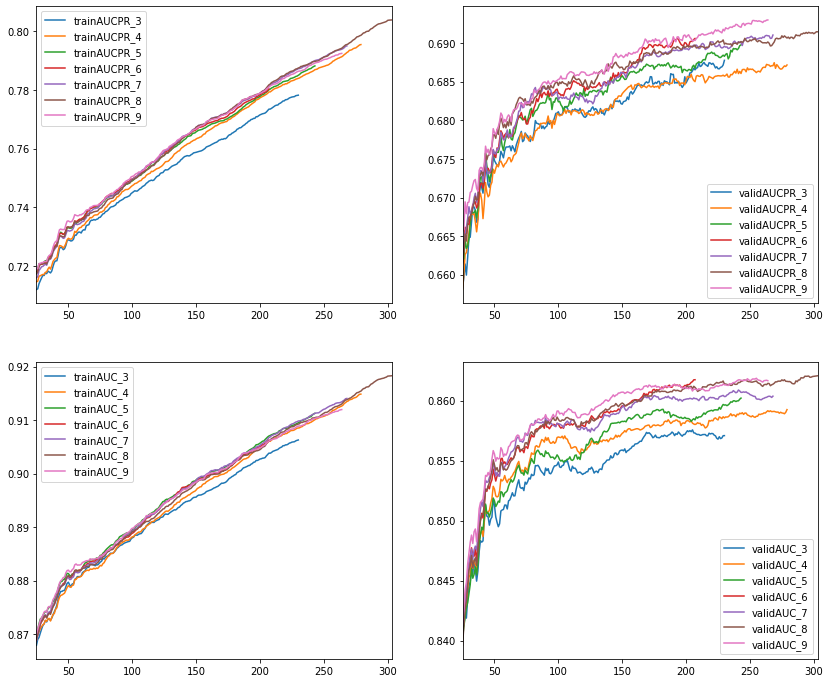

In [118]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, "Exited",
                                                          max_depth=5,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 25 obserwacji i pomijamy 50 ostatnich (early stopping)
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:-50].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:-50].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:-50].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:-50].plot(ax=ax[1, 1])
plt.show()

udział wierszy 0.6-0.9, na tym foldzie najlepiej wypadło 0.9, zatem będzie wykorzystane do testów.
 - udział kolumn,

0.3 0.687153
0.4 0.692326
0.5 0.693293
0.6 0.692045
0.7 0.693032
0.8 0.690648
0.9 0.689905


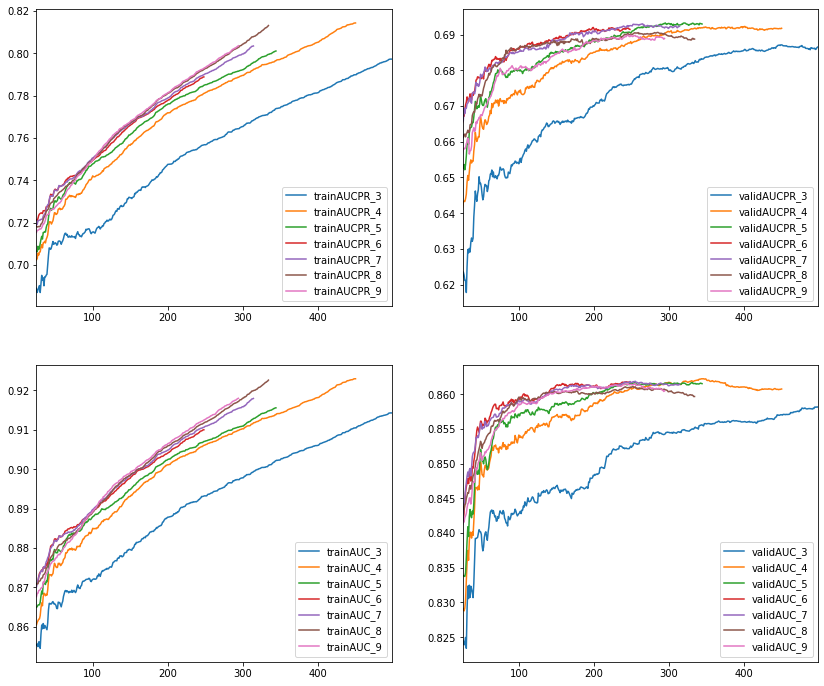

In [119]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, "Exited",
                                                          max_depth=5, subsample=0.9, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Wyniki z udziału kolumn (najlepsze 0.5 - 0.7) w prównaniu z nieobrobionym df (0.9) wskazują na redundancję zmiennych, co jest wytłumaczalne, bowiem nowe cechy powstały w oparciu o już istniejące, a drzewa losowe same znajdują najlepsze interakcje.
 - regularyzacja,

0 0.695241
1 0.693293
4 0.693322
9 0.691886
16 0.690472
25 0.687915
36 0.685408
49 0.683533


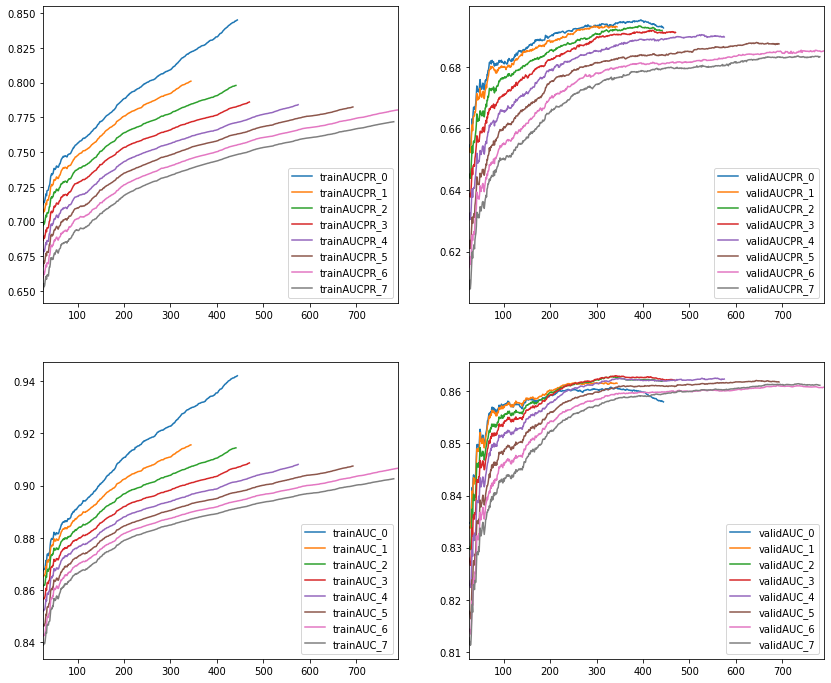

In [120]:
resHists = dict()

rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, "Exited", lambdaX=x**2,
                                                          max_depth=5, subsample=0.9, colsample_bytree=0.5,
                                                          early_stopping_rounds=50, debug=False)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Warto sprawdzić regularyzację poniżej 0.

1.0 0.693293
0.5 0.693036
0.3333333333333333 0.693906
0.25 0.693285
0.2 0.693778
0.16666666666666666 0.69429
0.14285714285714285 0.694267
0.125 0.694889
0.1111111111111111 0.695799
0.1 0.695342


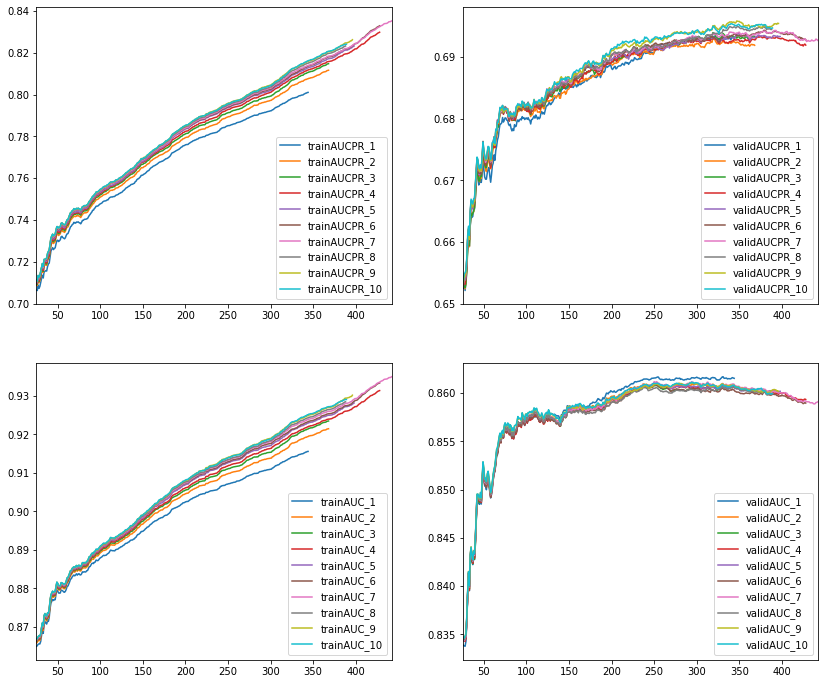

In [121]:
resHists = dict()

rang = range(1,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, "Exited", lambdaX=1/x,
                                                          max_depth=5, subsample=0.9, colsample_bytree=0.5,
                                                          early_stopping_rounds=50, debug=False)
    
    print(1/x, score)
    resHists[x]=train_history
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

minimalna regularyzacja jest pomocna, w tym przypadku 1/9, sensowny zakres to 1/10 - 1/8.
 - gamma,

0 0.695799
0.01 0.69578
0.1 0.695871
0.5 0.695181
1 0.694014
2 0.694338
5 0.696685


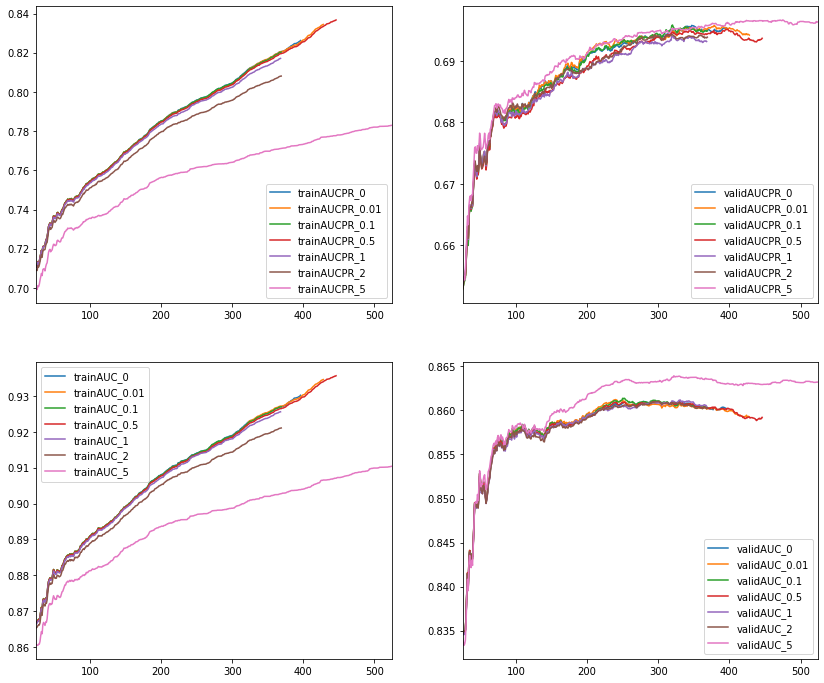

In [122]:
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_eng, "Exited", lambdaX=1/9,
                                                          max_depth=5, subsample=0.9, colsample_bytree=0.5,
                                                          gamma=x,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Brak korzyści z wykorzystania gammy.
##### Walidacja krzyżowa XGB

In [123]:
'''from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score'''


# Przygotujmy prosty wrapper
def CVTestXGB(df = dffin, nFolds = 5, randomState=2020, features=features_eng, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values, df.Exited):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, 'Exited', debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        ROCtrainScore = roc_auc_score(df['Exited'].iloc[train], trainPred)
        ROCtestScore = roc_auc_score(df['Exited'].iloc[test], testPred)
        PRtrainScore = average_precision_score(df['Exited'].iloc[train], trainPred)
        PRtestScore = average_precision_score(df['Exited'].iloc[test], testPred)
        
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", ROCtrainScore,
                  "Valid AUC:", ROCtestScore, 
                  "Train PR:", PRtrainScore,
                  "Valid PR:", PRtestScore)
        
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, pd.concat(hists, axis=1)

eta 0.03, max_depth 5, subsample 0.9, colsample_bytree 0.5, colsample_bylevel 1, lambdaX 0.1111111111111111, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc', 'aucpr'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 8000
Length valid: 2000
[0]	train-auc:0.717087	train-aucpr:0.474561	valid-auc:0.709906	valid-aucpr:0.454774
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[1]	train-auc:0.782669	train-aucpr:0.582083	valid-auc:0.765605	valid-aucpr:0.540791
[2]	train-auc:0.850612	train-aucpr:0.675832	valid-auc:0.831886	valid-aucpr:0.630795
[3]	train-auc:0.850163	train-aucpr:0.662538	valid-auc:0.824207	valid-aucpr:0.607714
[4]	train-auc:0.856105	train-aucpr:0.692268	valid-auc:0.830473	valid-aucpr:0.634142
[5]	train-auc:0.859424	train-aucpr:0.699075

[91]	train-auc:0.88923	train-aucpr:0.752243	valid-auc:0.855364	valid-aucpr:0.688832
[92]	train-auc:0.889095	train-aucpr:0.752195	valid-auc:0.855435	valid-aucpr:0.688659
[93]	train-auc:0.889506	train-aucpr:0.753104	valid-auc:0.855489	valid-aucpr:0.688566
[94]	train-auc:0.889541	train-aucpr:0.753437	valid-auc:0.855475	valid-aucpr:0.689054
[95]	train-auc:0.890049	train-aucpr:0.754222	valid-auc:0.855951	valid-aucpr:0.689328
[96]	train-auc:0.889985	train-aucpr:0.754152	valid-auc:0.855969	valid-aucpr:0.689645
[97]	train-auc:0.889857	train-aucpr:0.754371	valid-auc:0.855765	valid-aucpr:0.689307
[98]	train-auc:0.890096	train-aucpr:0.754504	valid-auc:0.855831	valid-aucpr:0.689256
[99]	train-auc:0.890447	train-aucpr:0.755051	valid-auc:0.855788	valid-aucpr:0.688828
[100]	train-auc:0.890837	train-aucpr:0.755303	valid-auc:0.855852	valid-aucpr:0.688362
[101]	train-auc:0.891175	train-aucpr:0.755623	valid-auc:0.855999	valid-aucpr:0.688639
[102]	train-auc:0.891412	train-aucpr:0.755823	valid-auc:0.856117

[187]	train-auc:0.906958	train-aucpr:0.783358	valid-auc:0.859575	valid-aucpr:0.694387
[188]	train-auc:0.907017	train-aucpr:0.783444	valid-auc:0.859509	valid-aucpr:0.694642
[189]	train-auc:0.907241	train-aucpr:0.783864	valid-auc:0.859792	valid-aucpr:0.694848
[190]	train-auc:0.907314	train-aucpr:0.784081	valid-auc:0.85974	valid-aucpr:0.694814
[191]	train-auc:0.907621	train-aucpr:0.784423	valid-auc:0.859711	valid-aucpr:0.694754
[192]	train-auc:0.907699	train-aucpr:0.78461	valid-auc:0.859748	valid-aucpr:0.695
[193]	train-auc:0.907829	train-aucpr:0.784933	valid-auc:0.859933	valid-aucpr:0.695196
[194]	train-auc:0.908123	train-aucpr:0.785402	valid-auc:0.859981	valid-aucpr:0.695562
[195]	train-auc:0.908287	train-aucpr:0.78569	valid-auc:0.859888	valid-aucpr:0.695569
[196]	train-auc:0.908397	train-aucpr:0.786014	valid-auc:0.859801	valid-aucpr:0.695342
[197]	train-auc:0.908677	train-aucpr:0.78663	valid-auc:0.859651	valid-aucpr:0.694493
[198]	train-auc:0.908706	train-aucpr:0.786696	valid-auc:0.859

[28]	train-auc:0.864623	train-aucpr:0.708824	valid-auc:0.849478	valid-aucpr:0.683025
[29]	train-auc:0.864308	train-aucpr:0.709095	valid-auc:0.849544	valid-aucpr:0.684163
[30]	train-auc:0.865156	train-aucpr:0.711398	valid-auc:0.850314	valid-aucpr:0.685393
[31]	train-auc:0.866968	train-aucpr:0.714258	valid-auc:0.852531	valid-aucpr:0.688211
[32]	train-auc:0.867864	train-aucpr:0.715501	valid-auc:0.854012	valid-aucpr:0.690378
[33]	train-auc:0.86721	train-aucpr:0.713927	valid-auc:0.853251	valid-aucpr:0.688366
[34]	train-auc:0.870081	train-aucpr:0.717917	valid-auc:0.855895	valid-aucpr:0.691008
[35]	train-auc:0.870812	train-aucpr:0.718293	valid-auc:0.856568	valid-aucpr:0.690599
[36]	train-auc:0.87045	train-aucpr:0.718728	valid-auc:0.85619	valid-aucpr:0.691955
[37]	train-auc:0.870262	train-aucpr:0.718543	valid-auc:0.855721	valid-aucpr:0.690529
[38]	train-auc:0.870696	train-aucpr:0.720432	valid-auc:0.856816	valid-aucpr:0.692354
[39]	train-auc:0.870602	train-aucpr:0.721502	valid-auc:0.856793	vali

[125]	train-auc:0.892333	train-aucpr:0.756189	valid-auc:0.869605	valid-aucpr:0.711044
[126]	train-auc:0.892559	train-aucpr:0.756649	valid-auc:0.869802	valid-aucpr:0.711509
[127]	train-auc:0.892615	train-aucpr:0.756841	valid-auc:0.869744	valid-aucpr:0.711811
[128]	train-auc:0.892602	train-aucpr:0.756871	valid-auc:0.869559	valid-aucpr:0.711476
[129]	train-auc:0.892979	train-aucpr:0.757445	valid-auc:0.869756	valid-aucpr:0.711835
[130]	train-auc:0.89302	train-aucpr:0.757777	valid-auc:0.869859	valid-aucpr:0.712305
[131]	train-auc:0.893076	train-aucpr:0.758044	valid-auc:0.869964	valid-aucpr:0.712895
[132]	train-auc:0.893193	train-aucpr:0.758236	valid-auc:0.869935	valid-aucpr:0.712835
[133]	train-auc:0.893316	train-aucpr:0.758527	valid-auc:0.869995	valid-aucpr:0.712864
[134]	train-auc:0.893408	train-aucpr:0.758632	valid-auc:0.869981	valid-aucpr:0.713017
[135]	train-auc:0.893598	train-aucpr:0.758811	valid-auc:0.869952	valid-aucpr:0.713015
[136]	train-auc:0.893918	train-aucpr:0.759392	valid-auc

[221]	train-auc:0.909608	train-aucpr:0.785713	valid-auc:0.872875	valid-aucpr:0.720345
[222]	train-auc:0.909603	train-aucpr:0.78572	valid-auc:0.872918	valid-aucpr:0.720544
[223]	train-auc:0.909741	train-aucpr:0.785868	valid-auc:0.872963	valid-aucpr:0.720689
[224]	train-auc:0.910067	train-aucpr:0.786199	valid-auc:0.873036	valid-aucpr:0.720538
[225]	train-auc:0.910131	train-aucpr:0.786464	valid-auc:0.873091	valid-aucpr:0.720762
[226]	train-auc:0.910118	train-aucpr:0.786475	valid-auc:0.873122	valid-aucpr:0.720873
[227]	train-auc:0.910354	train-aucpr:0.786753	valid-auc:0.873129	valid-aucpr:0.720837
[228]	train-auc:0.910513	train-aucpr:0.786934	valid-auc:0.873179	valid-aucpr:0.721028
[229]	train-auc:0.910621	train-aucpr:0.787078	valid-auc:0.873146	valid-aucpr:0.721019
[230]	train-auc:0.910685	train-aucpr:0.787181	valid-auc:0.873094	valid-aucpr:0.721084
[231]	train-auc:0.910679	train-aucpr:0.78724	valid-auc:0.873078	valid-aucpr:0.720927
[232]	train-auc:0.910752	train-aucpr:0.787419	valid-auc:

[6]	train-auc:0.854666	train-aucpr:0.698327	valid-auc:0.845131	valid-aucpr:0.641078
[7]	train-auc:0.852207	train-aucpr:0.69364	valid-auc:0.84395	valid-aucpr:0.636769
[8]	train-auc:0.855193	train-aucpr:0.695495	valid-auc:0.847735	valid-aucpr:0.642997
[9]	train-auc:0.852428	train-aucpr:0.695247	valid-auc:0.845456	valid-aucpr:0.645228
[10]	train-auc:0.859213	train-aucpr:0.703993	valid-auc:0.852476	valid-aucpr:0.652274
[11]	train-auc:0.857838	train-aucpr:0.70181	valid-auc:0.851347	valid-aucpr:0.649287
[12]	train-auc:0.856191	train-aucpr:0.701645	valid-auc:0.850265	valid-aucpr:0.650489
[13]	train-auc:0.857594	train-aucpr:0.702434	valid-auc:0.852605	valid-aucpr:0.654674
[14]	train-auc:0.856391	train-aucpr:0.702532	valid-auc:0.851651	valid-aucpr:0.65476
[15]	train-auc:0.854991	train-aucpr:0.698607	valid-auc:0.849726	valid-aucpr:0.650842
[16]	train-auc:0.853177	train-aucpr:0.694361	valid-auc:0.84762	valid-aucpr:0.646785
[17]	train-auc:0.852477	train-aucpr:0.691667	valid-auc:0.847017	valid-aucp

[104]	train-auc:0.889124	train-aucpr:0.754189	valid-auc:0.871074	valid-aucpr:0.693484
[105]	train-auc:0.889011	train-aucpr:0.754336	valid-auc:0.871027	valid-aucpr:0.693851
[106]	train-auc:0.889113	train-aucpr:0.754488	valid-auc:0.871196	valid-aucpr:0.694185
[107]	train-auc:0.889228	train-aucpr:0.75453	valid-auc:0.871111	valid-aucpr:0.693786
[108]	train-auc:0.889694	train-aucpr:0.755165	valid-auc:0.871022	valid-aucpr:0.69388
[109]	train-auc:0.889863	train-aucpr:0.755183	valid-auc:0.871266	valid-aucpr:0.693882
[110]	train-auc:0.890121	train-aucpr:0.755782	valid-auc:0.871506	valid-aucpr:0.693702
[111]	train-auc:0.89032	train-aucpr:0.755992	valid-auc:0.871687	valid-aucpr:0.693765
[112]	train-auc:0.890661	train-aucpr:0.756238	valid-auc:0.871786	valid-aucpr:0.693936
[113]	train-auc:0.890675	train-aucpr:0.75641	valid-auc:0.871701	valid-aucpr:0.693876
[114]	train-auc:0.890663	train-aucpr:0.756389	valid-auc:0.871654	valid-aucpr:0.694067
[115]	train-auc:0.890778	train-aucpr:0.756736	valid-auc:0.

[200]	train-auc:0.905829	train-aucpr:0.781982	valid-auc:0.874613	valid-aucpr:0.702997
[201]	train-auc:0.906136	train-aucpr:0.782563	valid-auc:0.874685	valid-aucpr:0.703106
[202]	train-auc:0.906256	train-aucpr:0.782667	valid-auc:0.874739	valid-aucpr:0.703243
[203]	train-auc:0.906205	train-aucpr:0.782642	valid-auc:0.874761	valid-aucpr:0.70346
[204]	train-auc:0.90636	train-aucpr:0.782962	valid-auc:0.874696	valid-aucpr:0.703417
[205]	train-auc:0.906599	train-aucpr:0.78331	valid-auc:0.874583	valid-aucpr:0.703205
[206]	train-auc:0.906777	train-aucpr:0.783557	valid-auc:0.874569	valid-aucpr:0.703212
[207]	train-auc:0.906943	train-aucpr:0.783874	valid-auc:0.87475	valid-aucpr:0.703673
[208]	train-auc:0.907017	train-aucpr:0.784081	valid-auc:0.874704	valid-aucpr:0.703606
[209]	train-auc:0.907169	train-aucpr:0.784277	valid-auc:0.874645	valid-aucpr:0.703435
[210]	train-auc:0.90713	train-aucpr:0.784274	valid-auc:0.874705	valid-aucpr:0.703616
[211]	train-auc:0.907303	train-aucpr:0.784576	valid-auc:0.8

[9]	train-auc:0.856534	train-aucpr:0.701187	valid-auc:0.8282	valid-aucpr:0.64813
[10]	train-auc:0.863079	train-aucpr:0.708538	valid-auc:0.830724	valid-aucpr:0.64985
[11]	train-auc:0.86085	train-aucpr:0.703673	valid-auc:0.829261	valid-aucpr:0.644564
[12]	train-auc:0.859796	train-aucpr:0.703896	valid-auc:0.828613	valid-aucpr:0.648504
[13]	train-auc:0.86167	train-aucpr:0.705038	valid-auc:0.830098	valid-aucpr:0.650431
[14]	train-auc:0.860261	train-aucpr:0.704781	valid-auc:0.829191	valid-aucpr:0.652614
[15]	train-auc:0.859272	train-aucpr:0.701929	valid-auc:0.826917	valid-aucpr:0.646749
[16]	train-auc:0.858133	train-aucpr:0.698307	valid-auc:0.824629	valid-aucpr:0.641666
[17]	train-auc:0.857744	train-aucpr:0.695955	valid-auc:0.824155	valid-aucpr:0.639346
[18]	train-auc:0.861676	train-aucpr:0.703344	valid-auc:0.828441	valid-aucpr:0.650563
[19]	train-auc:0.861302	train-aucpr:0.704467	valid-auc:0.829009	valid-aucpr:0.653418
[20]	train-auc:0.862486	train-aucpr:0.705254	valid-auc:0.830065	valid-au

[106]	train-auc:0.891435	train-aucpr:0.755745	valid-auc:0.851266	valid-aucpr:0.688232
[107]	train-auc:0.89155	train-aucpr:0.755863	valid-auc:0.851388	valid-aucpr:0.688614
[108]	train-auc:0.891757	train-aucpr:0.756285	valid-auc:0.85127	valid-aucpr:0.688506
[109]	train-auc:0.891965	train-aucpr:0.756283	valid-auc:0.85124	valid-aucpr:0.688273
[110]	train-auc:0.892121	train-aucpr:0.756903	valid-auc:0.851251	valid-aucpr:0.688272
[111]	train-auc:0.892379	train-aucpr:0.757312	valid-auc:0.851061	valid-aucpr:0.68783
[112]	train-auc:0.892596	train-aucpr:0.757485	valid-auc:0.850828	valid-aucpr:0.687266
[113]	train-auc:0.892734	train-aucpr:0.757754	valid-auc:0.850643	valid-aucpr:0.687529
[114]	train-auc:0.892679	train-aucpr:0.758016	valid-auc:0.850633	valid-aucpr:0.687247
[115]	train-auc:0.892897	train-aucpr:0.758311	valid-auc:0.850474	valid-aucpr:0.686989
[116]	train-auc:0.892915	train-aucpr:0.758352	valid-auc:0.850449	valid-aucpr:0.687159
[117]	train-auc:0.892837	train-aucpr:0.758345	valid-auc:0.

[202]	train-auc:0.907885	train-aucpr:0.785583	valid-auc:0.855392	valid-aucpr:0.695717
[203]	train-auc:0.907828	train-aucpr:0.785544	valid-auc:0.855473	valid-aucpr:0.6959
[204]	train-auc:0.907975	train-aucpr:0.785736	valid-auc:0.855384	valid-aucpr:0.696036
[205]	train-auc:0.908079	train-aucpr:0.785987	valid-auc:0.855409	valid-aucpr:0.696069
[206]	train-auc:0.908208	train-aucpr:0.786206	valid-auc:0.855484	valid-aucpr:0.695955
[207]	train-auc:0.908257	train-aucpr:0.786405	valid-auc:0.855478	valid-aucpr:0.696019
[208]	train-auc:0.908371	train-aucpr:0.786696	valid-auc:0.855628	valid-aucpr:0.696201
[209]	train-auc:0.90866	train-aucpr:0.787022	valid-auc:0.855723	valid-aucpr:0.69626
[210]	train-auc:0.908683	train-aucpr:0.787164	valid-auc:0.855682	valid-aucpr:0.696154
[211]	train-auc:0.908937	train-aucpr:0.787611	valid-auc:0.855691	valid-aucpr:0.696175
[212]	train-auc:0.908942	train-aucpr:0.787595	valid-auc:0.855722	valid-aucpr:0.696166
[213]	train-auc:0.909177	train-aucpr:0.787921	valid-auc:0.

[1]	train-auc:0.783313	train-aucpr:0.580912	valid-auc:0.764248	valid-aucpr:0.545752
[2]	train-auc:0.847642	train-aucpr:0.660461	valid-auc:0.829136	valid-aucpr:0.633866
[3]	train-auc:0.847189	train-aucpr:0.648759	valid-auc:0.834722	valid-aucpr:0.617651
[4]	train-auc:0.850373	train-aucpr:0.675577	valid-auc:0.844512	valid-aucpr:0.666801
[5]	train-auc:0.854004	train-aucpr:0.684381	valid-auc:0.847423	valid-aucpr:0.683343
[6]	train-auc:0.852811	train-aucpr:0.688351	valid-auc:0.848683	valid-aucpr:0.686214
[7]	train-auc:0.849229	train-aucpr:0.682326	valid-auc:0.84651	valid-aucpr:0.686586
[8]	train-auc:0.852291	train-aucpr:0.683224	valid-auc:0.851453	valid-aucpr:0.693162
[9]	train-auc:0.85	train-aucpr:0.684831	valid-auc:0.84946	valid-aucpr:0.693657
[10]	train-auc:0.857292	train-aucpr:0.69384	valid-auc:0.856103	valid-aucpr:0.697628
[11]	train-auc:0.855386	train-aucpr:0.689748	valid-auc:0.85522	valid-aucpr:0.693958
[12]	train-auc:0.853711	train-aucpr:0.690425	valid-auc:0.854672	valid-aucpr:0.6970

[98]	train-auc:0.886303	train-aucpr:0.743557	valid-auc:0.87737	valid-aucpr:0.735236
[99]	train-auc:0.886656	train-aucpr:0.744137	valid-auc:0.877512	valid-aucpr:0.73545
[100]	train-auc:0.8871	train-aucpr:0.744567	valid-auc:0.877488	valid-aucpr:0.735433
[101]	train-auc:0.887345	train-aucpr:0.744791	valid-auc:0.877395	valid-aucpr:0.735652
[102]	train-auc:0.887509	train-aucpr:0.744993	valid-auc:0.877647	valid-aucpr:0.736218
[103]	train-auc:0.887756	train-aucpr:0.745585	valid-auc:0.877855	valid-aucpr:0.736153
[104]	train-auc:0.887798	train-aucpr:0.745733	valid-auc:0.877608	valid-aucpr:0.736117
[105]	train-auc:0.887677	train-aucpr:0.745822	valid-auc:0.877534	valid-aucpr:0.735937
[106]	train-auc:0.887732	train-aucpr:0.745809	valid-auc:0.877596	valid-aucpr:0.7358
[107]	train-auc:0.887804	train-aucpr:0.745905	valid-auc:0.877449	valid-aucpr:0.735598
[108]	train-auc:0.888153	train-aucpr:0.746408	valid-auc:0.877549	valid-aucpr:0.735991
[109]	train-auc:0.888255	train-aucpr:0.746434	valid-auc:0.8776

[194]	train-auc:0.903984	train-aucpr:0.774831	valid-auc:0.879787	valid-aucpr:0.741398
[195]	train-auc:0.904113	train-aucpr:0.775091	valid-auc:0.879669	valid-aucpr:0.741346
[196]	train-auc:0.904243	train-aucpr:0.775278	valid-auc:0.879695	valid-aucpr:0.741385
[197]	train-auc:0.904643	train-aucpr:0.77595	valid-auc:0.879585	valid-aucpr:0.74096
[198]	train-auc:0.904738	train-aucpr:0.776226	valid-auc:0.879641	valid-aucpr:0.741012
[199]	train-auc:0.904834	train-aucpr:0.776447	valid-auc:0.87969	valid-aucpr:0.740849
[200]	train-auc:0.904945	train-aucpr:0.776669	valid-auc:0.879533	valid-aucpr:0.740677
[201]	train-auc:0.905011	train-aucpr:0.776861	valid-auc:0.879595	valid-aucpr:0.740771
[202]	train-auc:0.905089	train-aucpr:0.776989	valid-auc:0.879645	valid-aucpr:0.740878
[203]	train-auc:0.905053	train-aucpr:0.776967	valid-auc:0.879665	valid-aucpr:0.740854
[204]	train-auc:0.905214	train-aucpr:0.777294	valid-auc:0.879661	valid-aucpr:0.740824
[205]	train-auc:0.905412	train-aucpr:0.777636	valid-auc:0

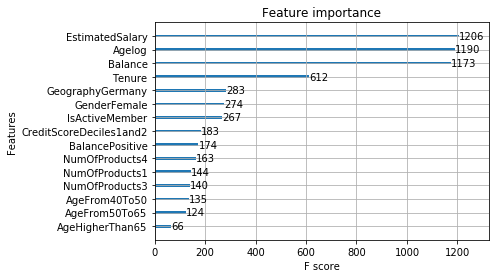

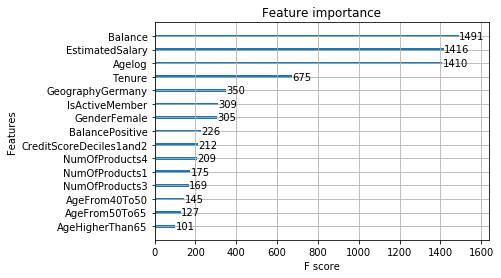

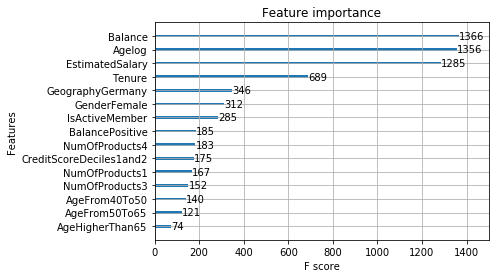

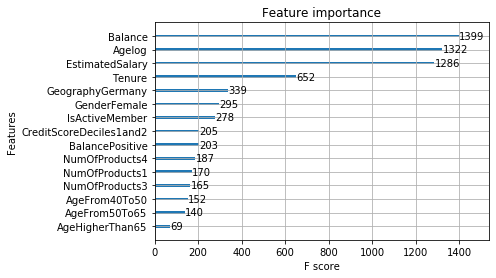

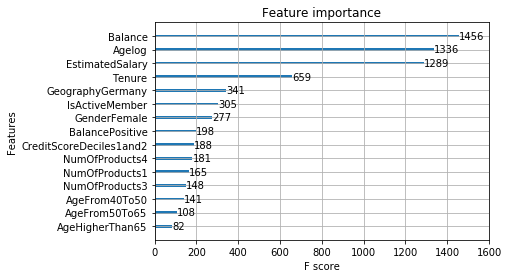

In [126]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dffin,
    features = features_eng, max_depth=5, lambdaX=1/9, subsample=0.9, colsample_bytree=0.5, gamma=0, debug=True)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}b'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

In [127]:
features_eng

['Balance',
 'IsActiveMember',
 'Agelog',
 'GeographyGermany',
 'NumOfProducts1',
 'NumOfProducts3',
 'NumOfProducts4',
 'AgeFrom40To50',
 'AgeFrom50To65',
 'AgeHigherThan65',
 'CreditScoreDeciles1and2',
 'EstimatedSalary',
 'GenderFemale',
 'BalancePositive',
 'Tenure']

In [132]:
ftrs = features_eng.copy()
ftrs.remove('AgeHigherThan65')
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dffin,
    features = ftrs, max_depth=5, lambdaX=1/9, subsample=0.9, colsample_bytree=0.5, gamma=0, debug=False)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

ROC: 0.8687980185264008
PR: 0.7133943513451559
ROCtrain-test: 0.04342100670246807
PRtrain-test: 0.0777121914329133


In [133]:
ftrs.remove('AgeFrom50To65')
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dffin,
    features = ftrs, max_depth=5, lambdaX=1/9, subsample=0.9, colsample_bytree=0.5, gamma=0, debug=False)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

ROC: 0.8682331582415174
PR: 0.7108626286364419
ROCtrain-test: 0.039808203774594375
PRtrain-test: 0.07310802572886455


In [134]:
ftrs.append('AgeFrom50To65')
ftrs.remove('AgeFrom40To50')
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dffin,
    features = ftrs, max_depth=5, lambdaX=1/9, subsample=0.9, colsample_bytree=0.5, gamma=0, debug=False)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

ROC: 0.8688038503589887
PR: 0.7120804190181651
ROCtrain-test: 0.046018371402484215
PRtrain-test: 0.08237993537641186


In [135]:
ftrs.append('AgeFrom40To50')
ftrs.remove('NumOfProducts3')
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dffin,
    features = ftrs, max_depth=5, lambdaX=1/9, subsample=0.9, colsample_bytree=0.5, gamma=0, debug=False)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

ROC: 0.8389656456017361
PR: 0.6503862805670085
ROCtrain-test: 0.05386365773252577
PRtrain-test: 0.09275173471609954


In [136]:
ftrs.append('NumOfProducts3')

Inżynieria zmiennych nie pomogła w XGB. Jednocześnie powyższy test pokazał, ze nie ma sensu ponawiać ćwiczenia dla Random Forest.<br/>
##### zapis aktualnie wykorzystywanych Data Frame 

In [140]:
zapis_dffin = True

if zapis_dffin:
    with open("dffin.p", "wb") as fp:
        pickle.dump(dffin, fp)

In [144]:
zapis_df = True

if zapis_df:
    with open("df.p", "wb") as fp:
        pickle.dump(df, fp)

In [ ]:
kernelstop = time.time()
print('Uruchomienie całego kernela trwało: {}'.format(round(kernelstop-kernelstart), 2))